In [32]:
import numpy as np
import gc

In [33]:
from dataframe import Data
from SNANA_FITS_to_pd import read_fits
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
from io_utils import *

In [34]:
dataset_val = 0

In [35]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [36]:
if dataset_val == 0:
    dataset =  "PLAsTiCC"
    data_ob = load_PLAsTiCC_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids=data_ob.get_ids_of_event_type(64)
    color_band_dict = {0:'C4',1:'C2', 2:'C3', 3:'C1', 4:'k', 5:'C5'}

In [37]:
if dataset_val == 1:    
    dataset = "ZTF"
    data_ob = load_ztf_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids = object_ids
    color_band_dict = {b'g ':'C2', b'r ':'C3'}

In [38]:
from LightCurve import LightCurve

In [39]:
def predict_lt_curve(coeff, PCs):
    predict_comb = np.zeros_like(PCs.shape[1])
    for a,b in zip(PCs,coeff): predict_comb=np.add(predict_comb,b*a)
    return predict_comb

In [57]:
def calc_loss(coeff, PCs, light_curve_seg):
    index = light_curve_seg!=0
    y_pred = predict_lt_curve(coeff,PCs)
    diff = light_curve_seg - y_pred
    neg_index = y_pred<0
    diff = diff[(index)|(neg_index)]
    
    #diff = diff[index]
    
    error = np.sum(np.multiply(diff,diff))
    return error

In [58]:
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

In [59]:
PCs = np.load("PCs.npy")
PCs = PCs[0:3]
PCs.shape

(3, 51)

In [60]:
print(len(object_ids))

7848


In [61]:
def get_binned_time(df):
    return df[data_ob.time_col_name]-df[data_ob.time_col_name]%2

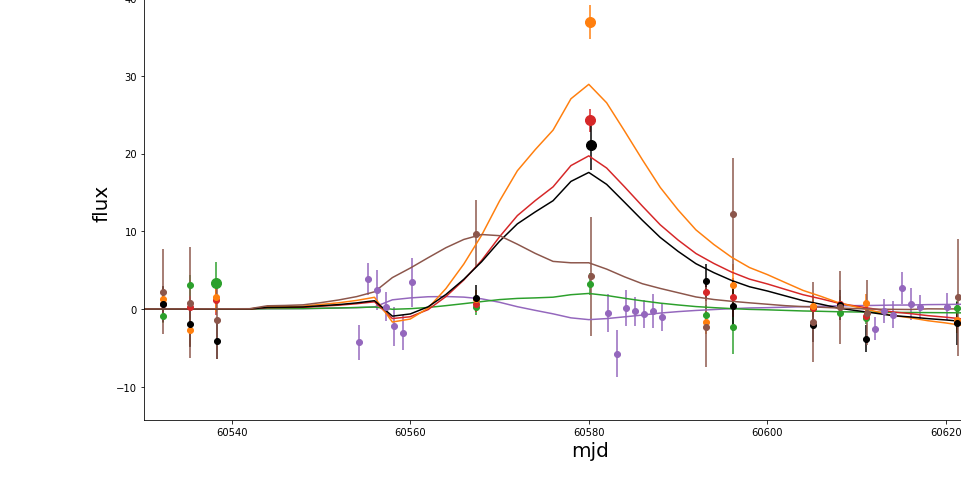

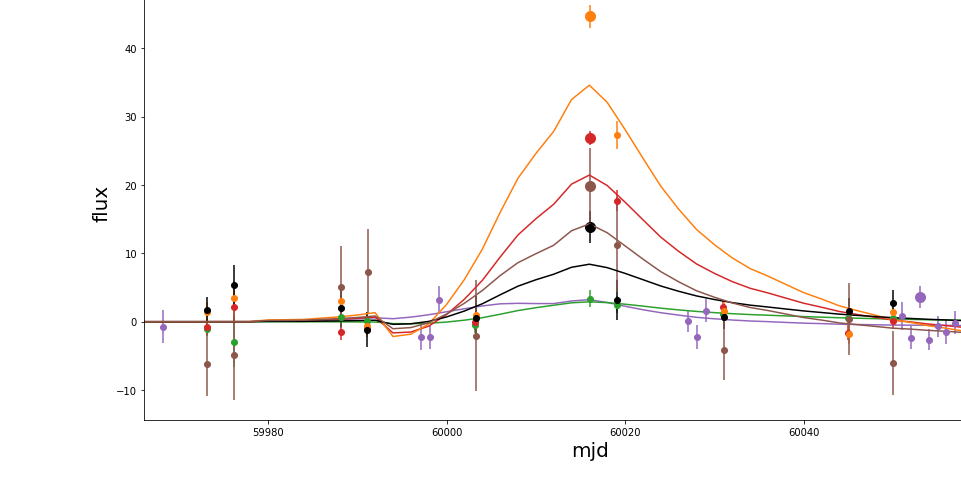

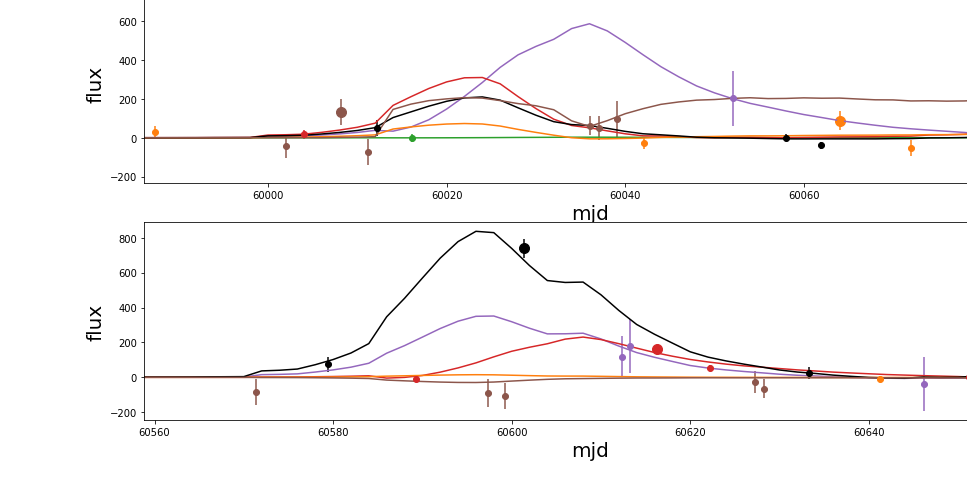

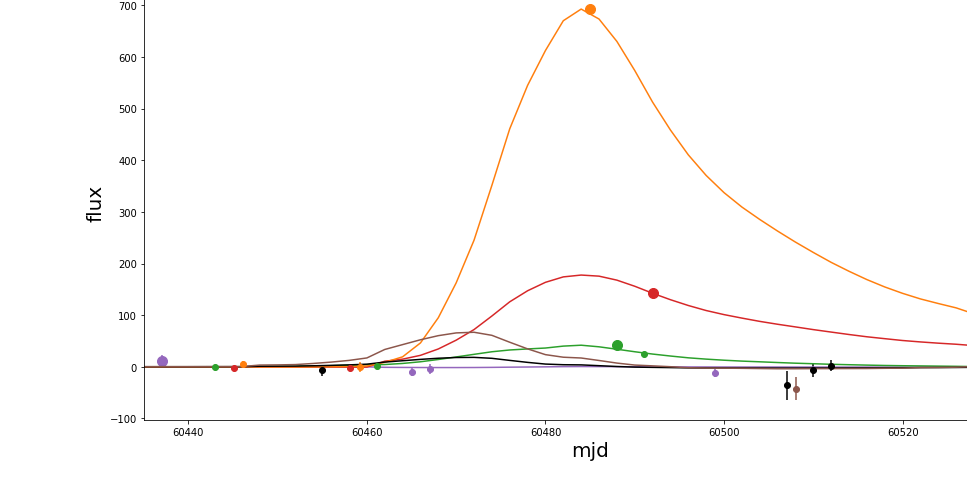

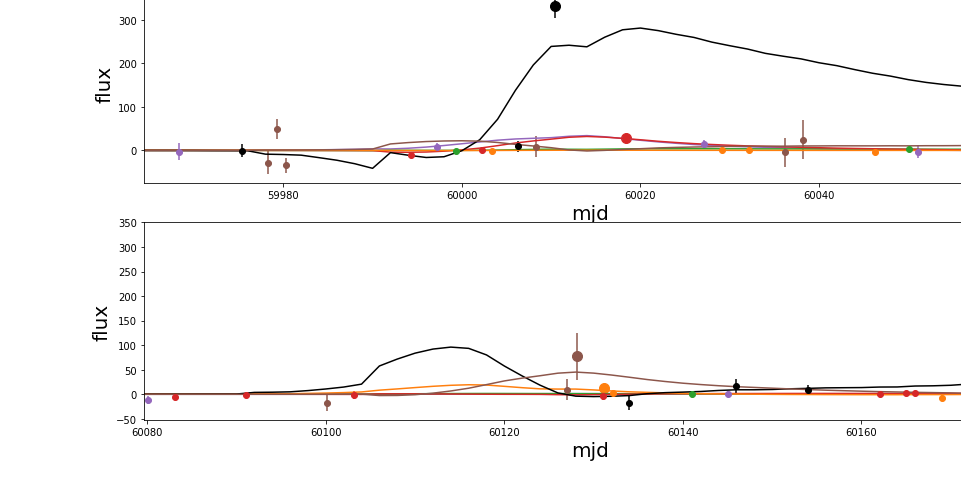

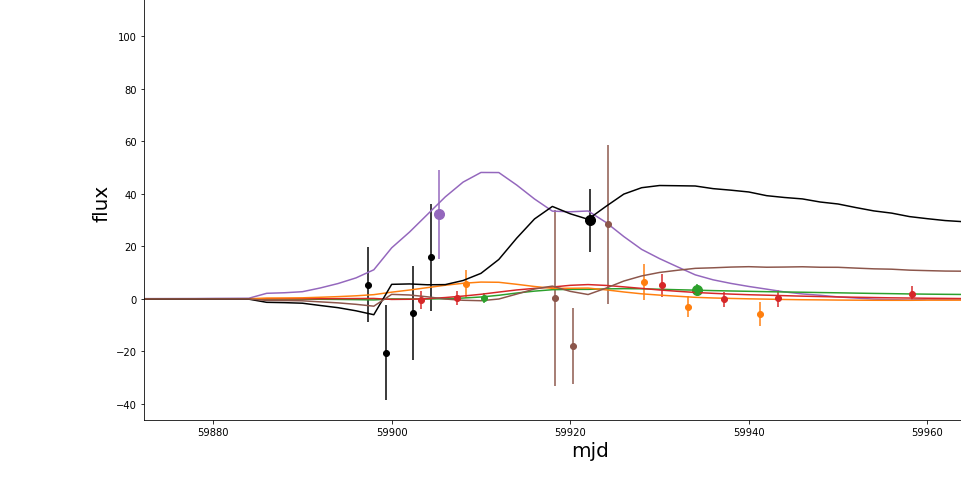

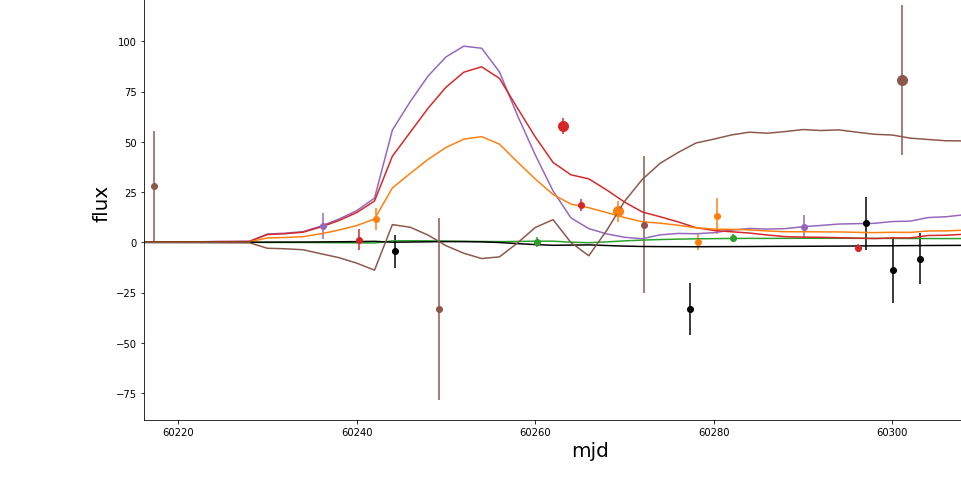

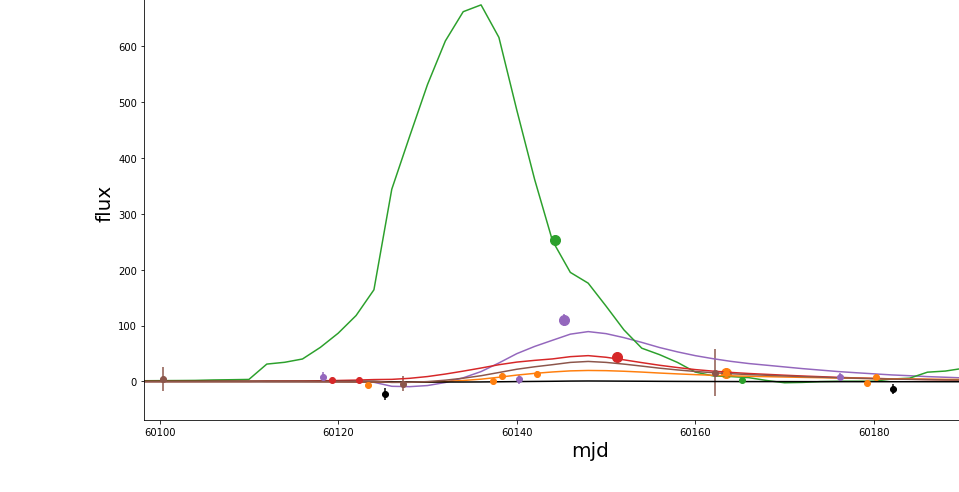

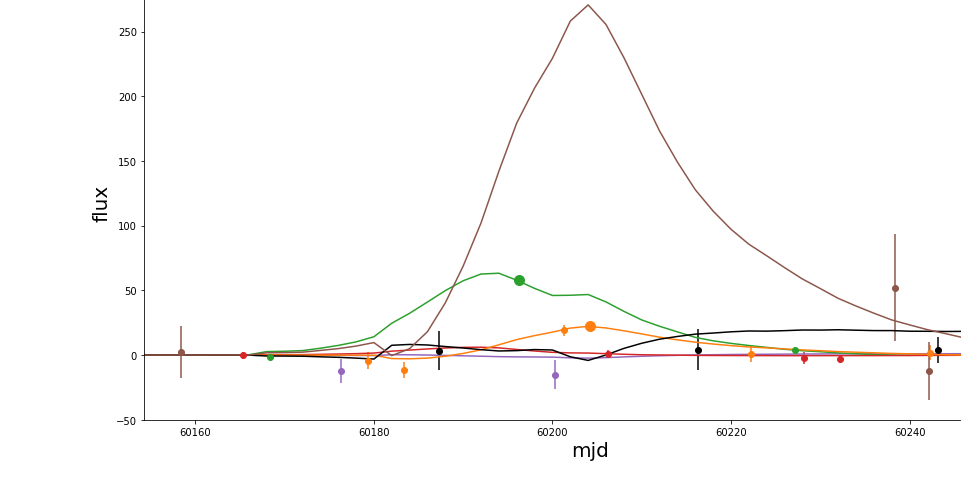

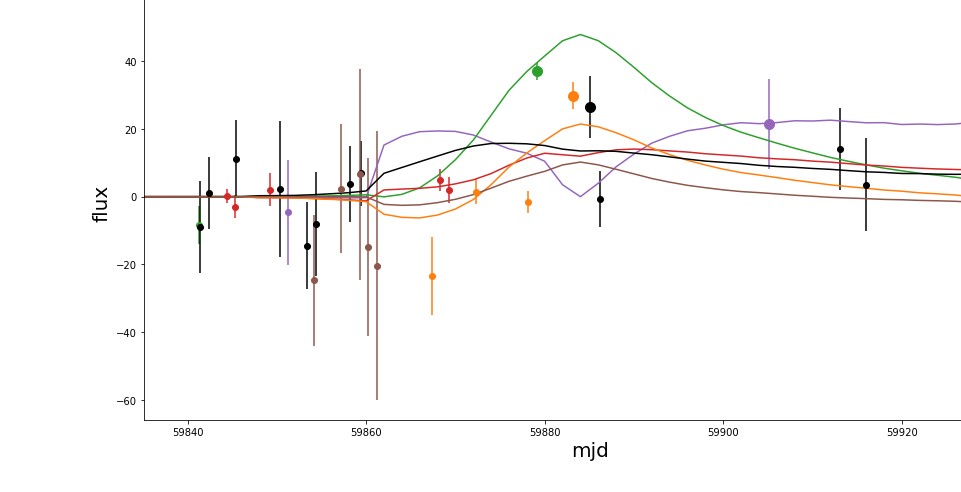

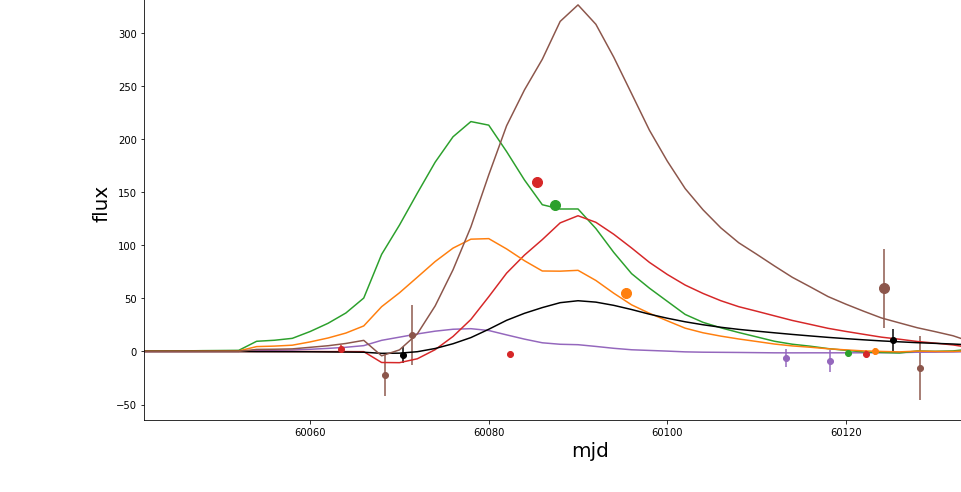

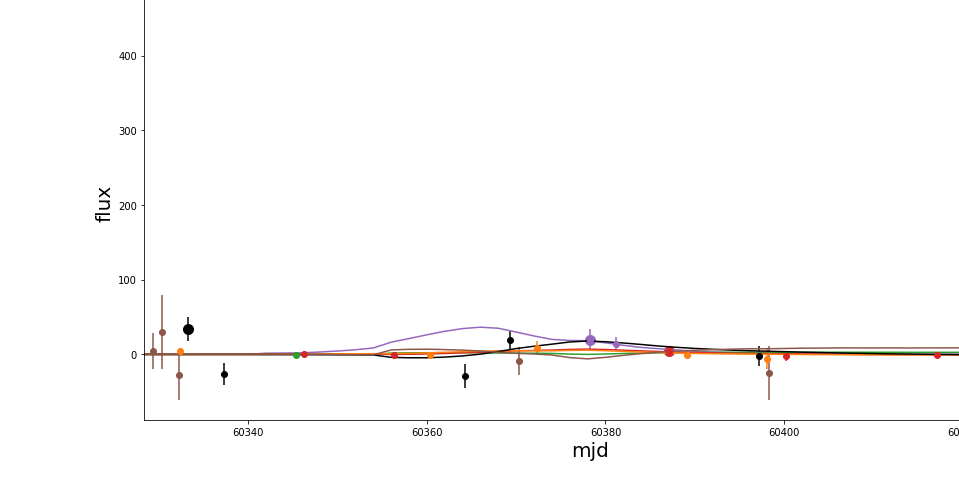

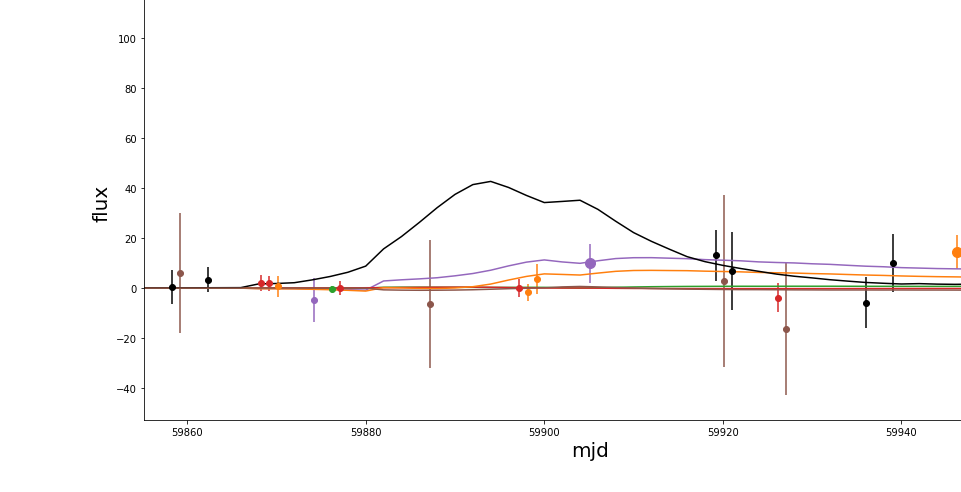

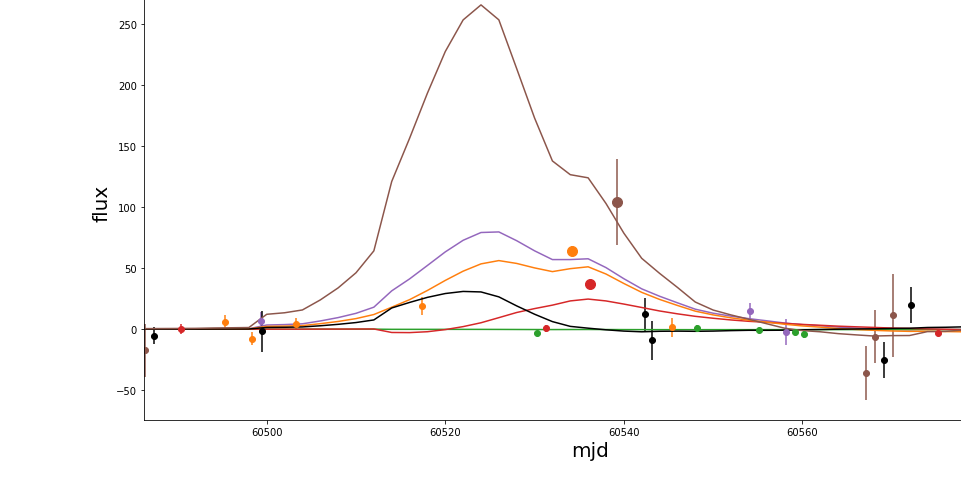

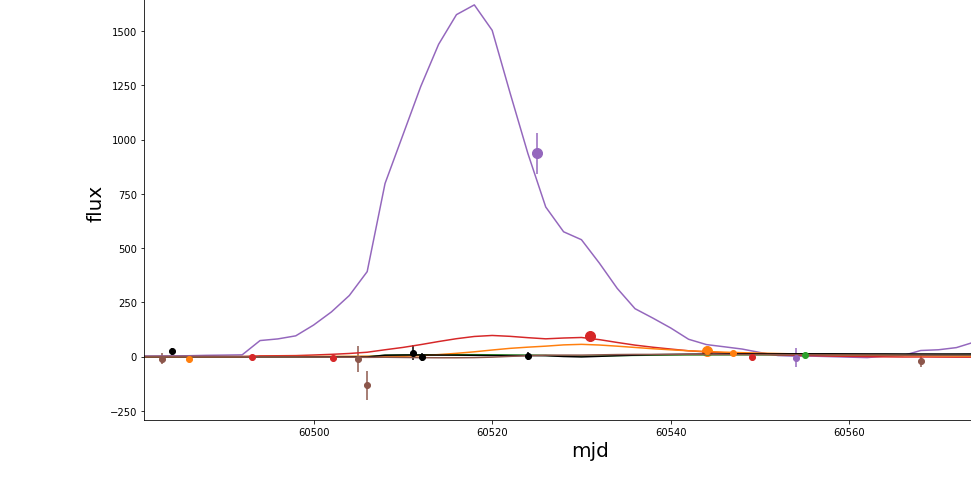

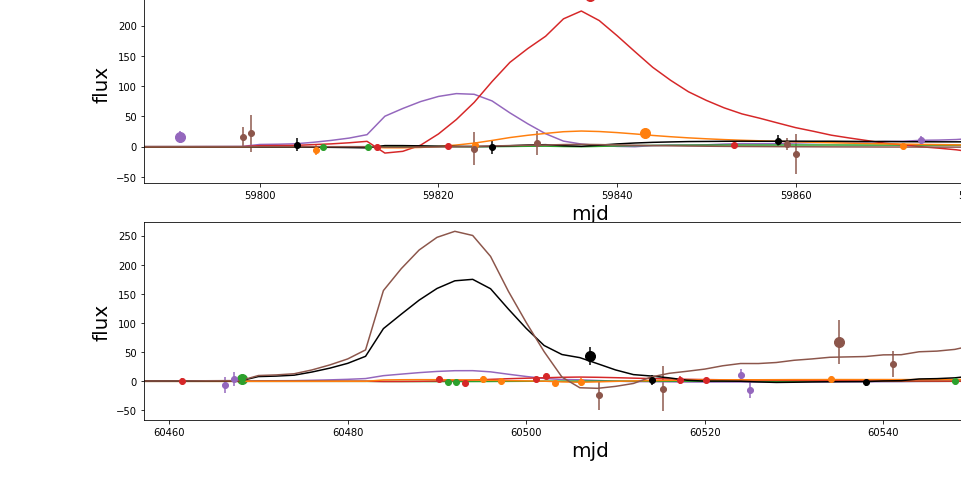

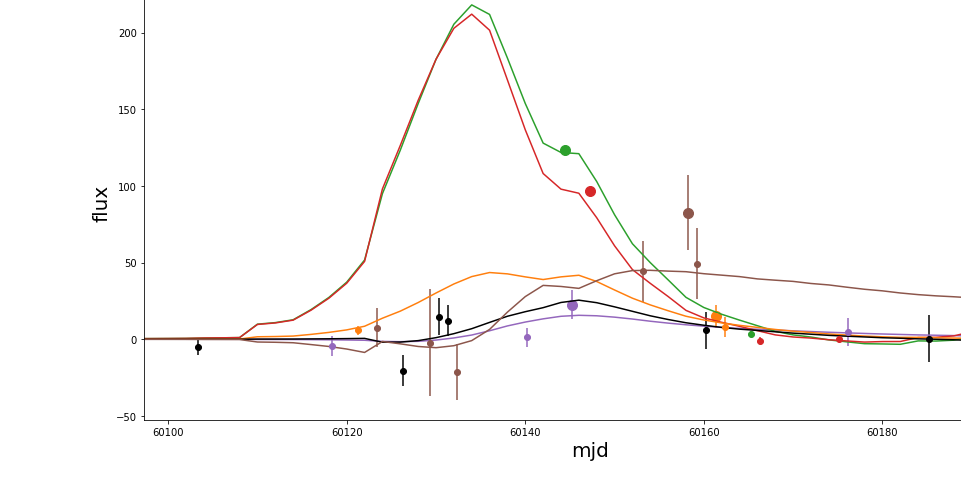

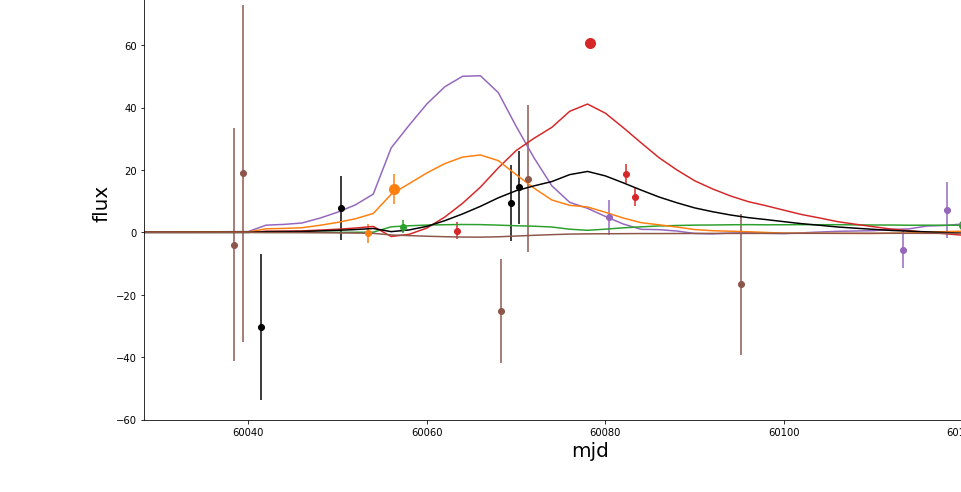

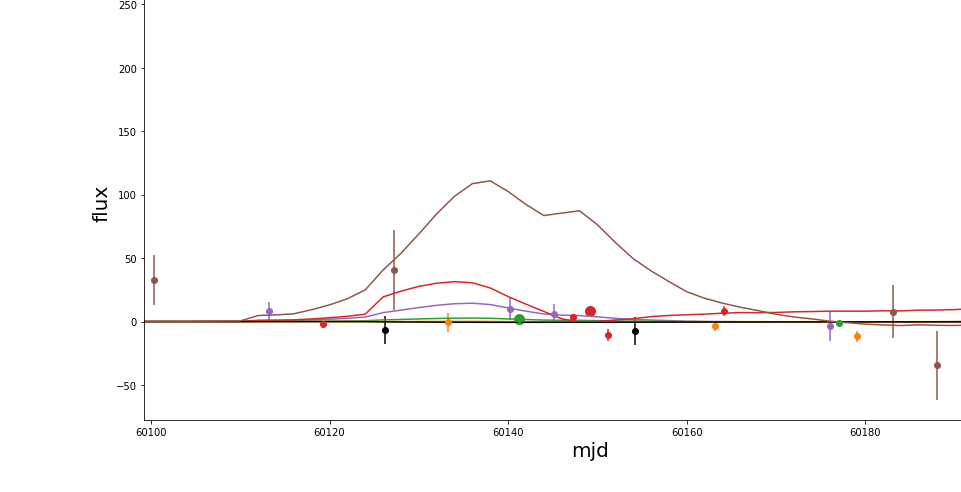

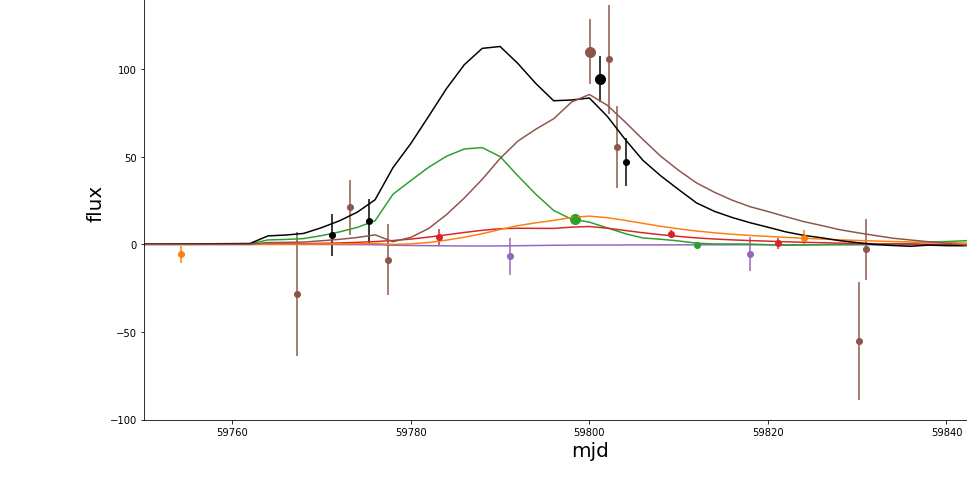

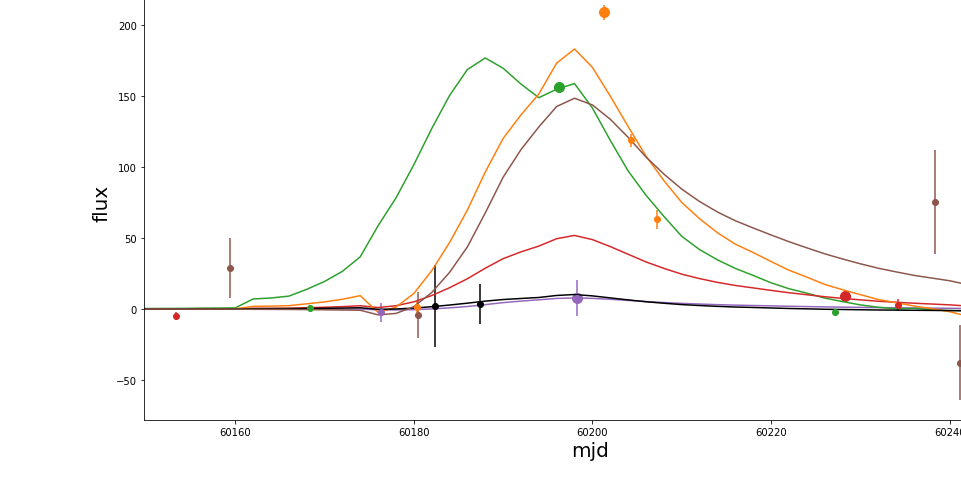

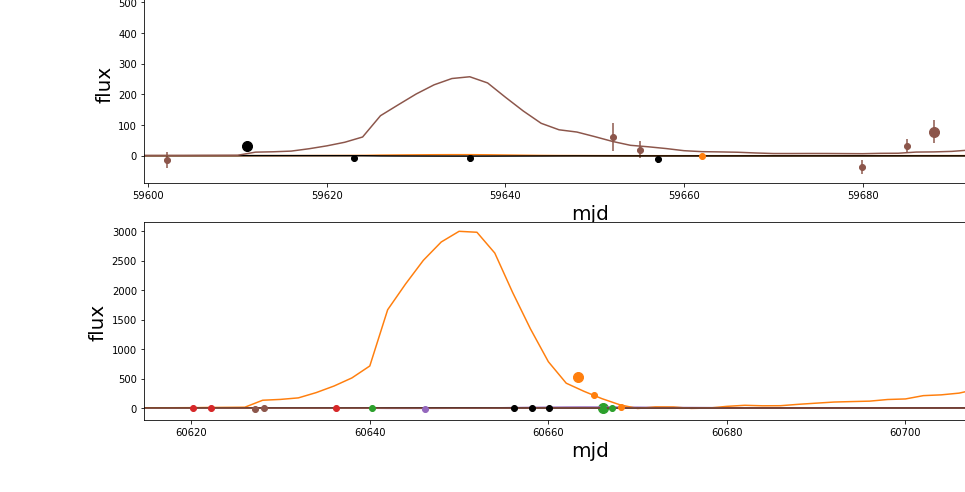

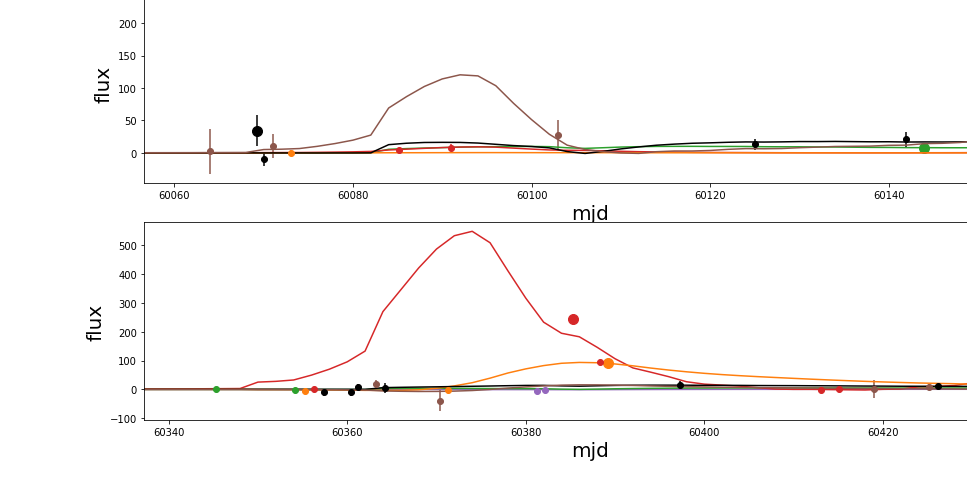

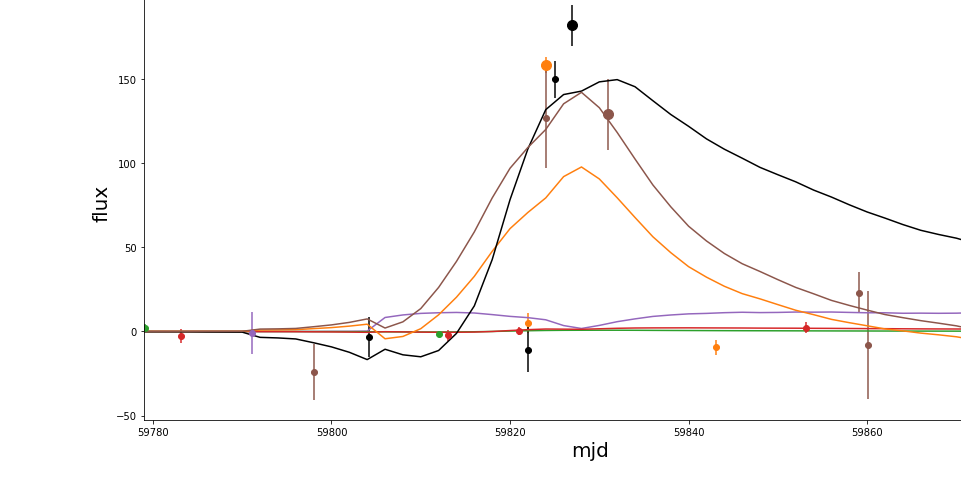

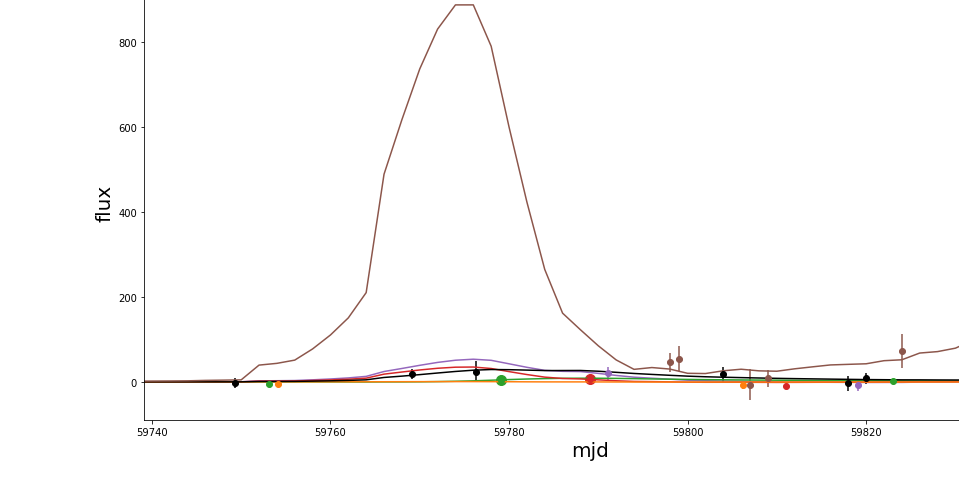

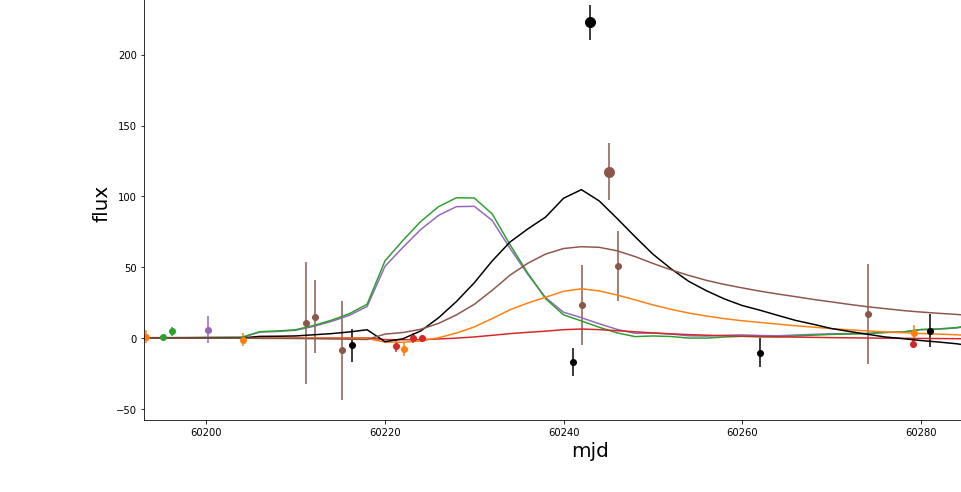

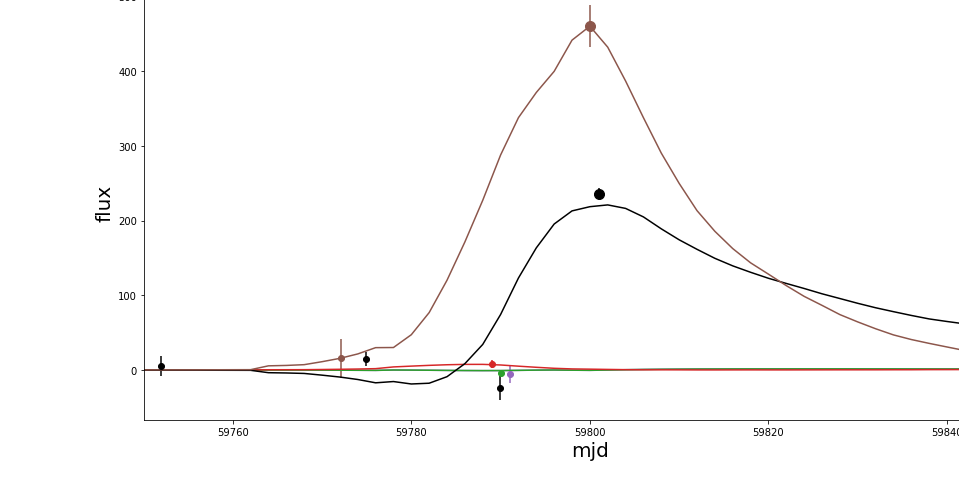

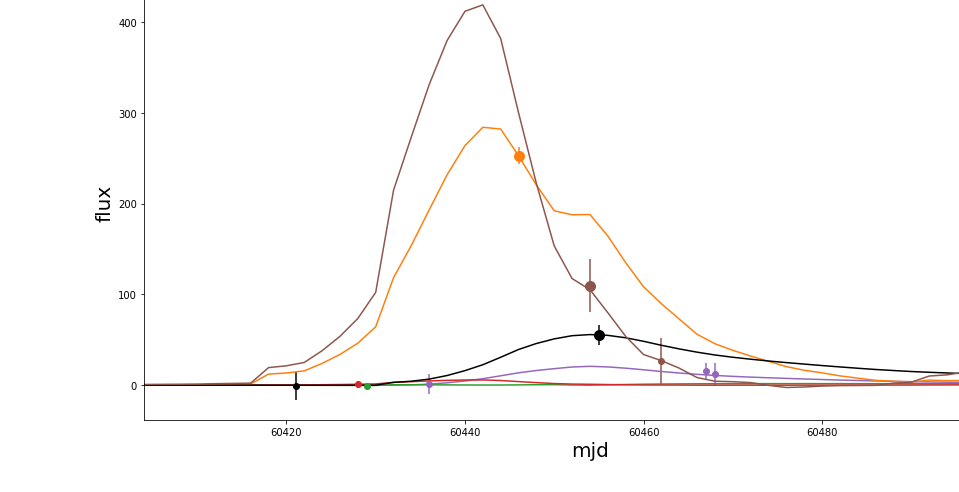

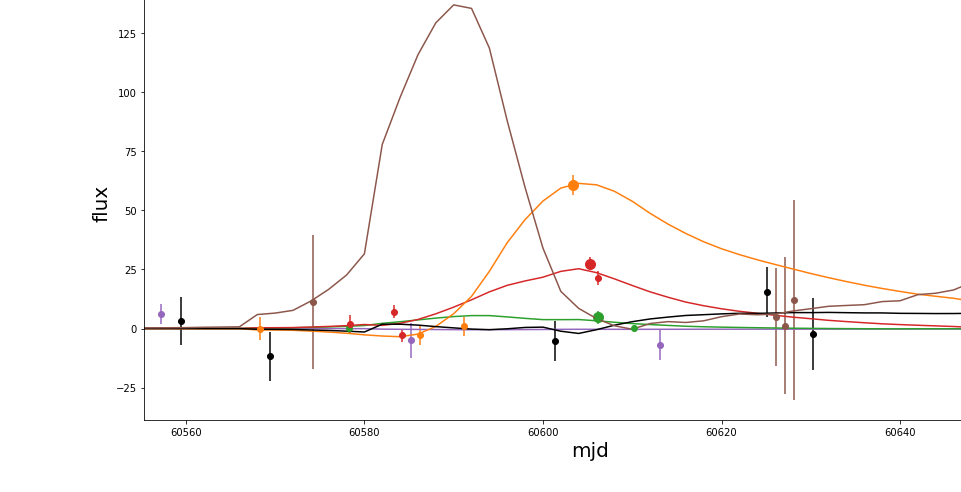

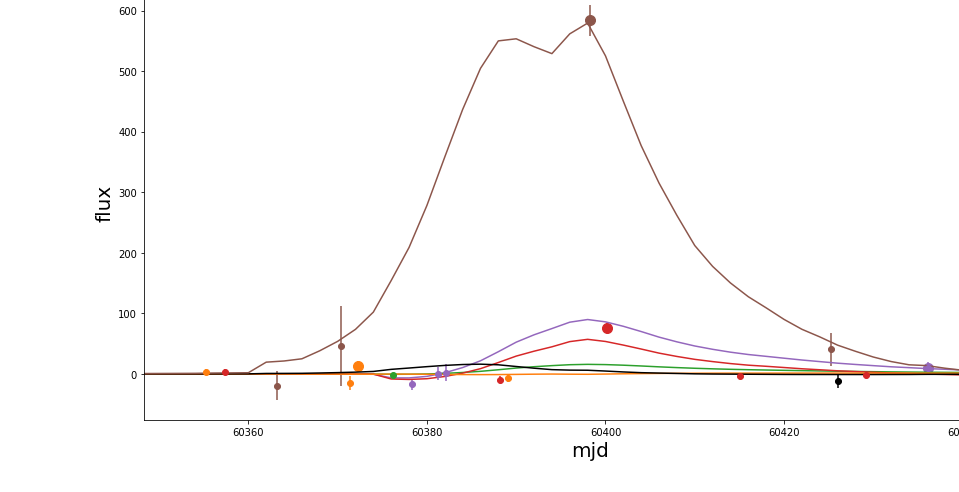

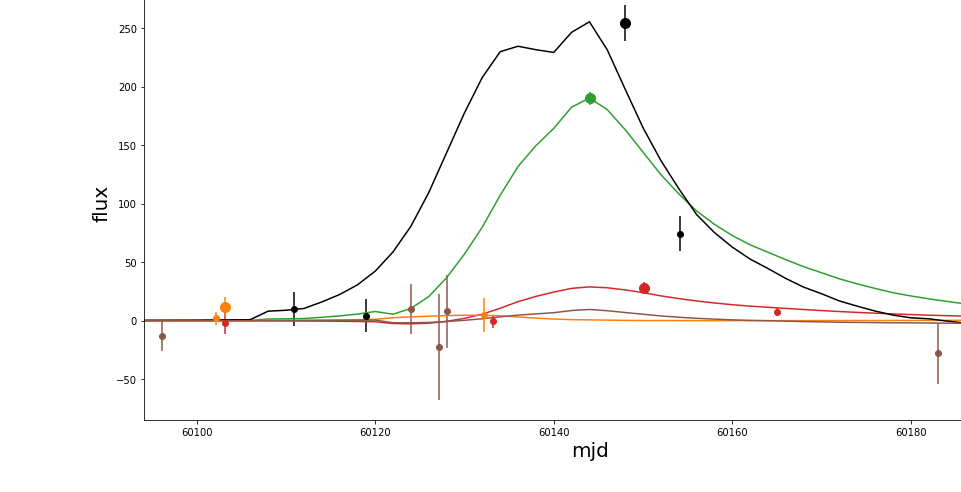

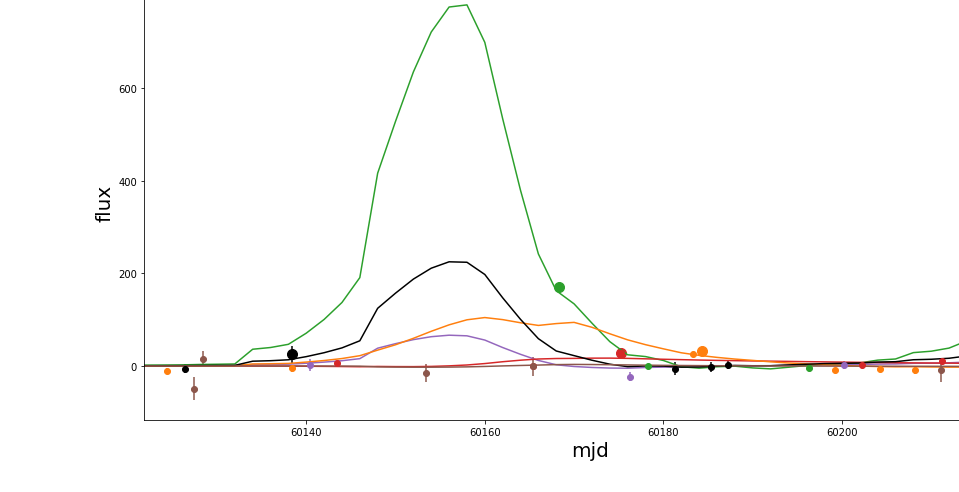

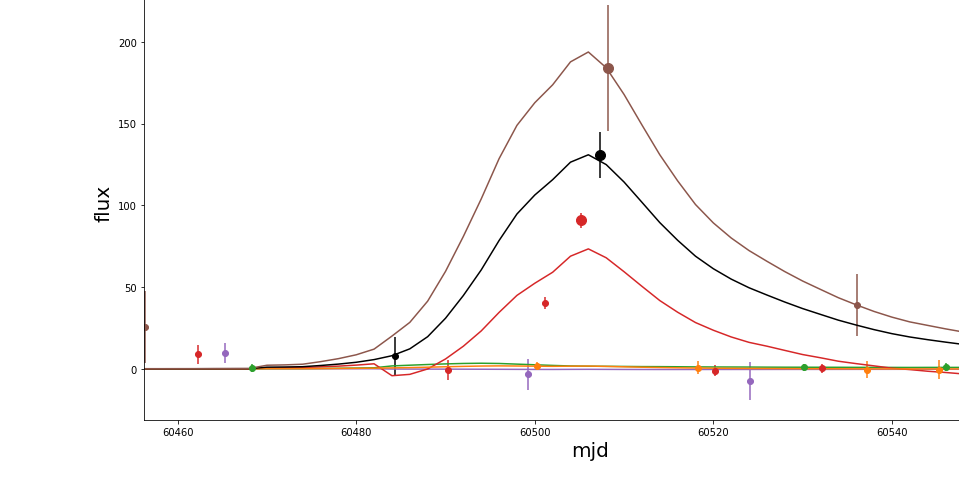

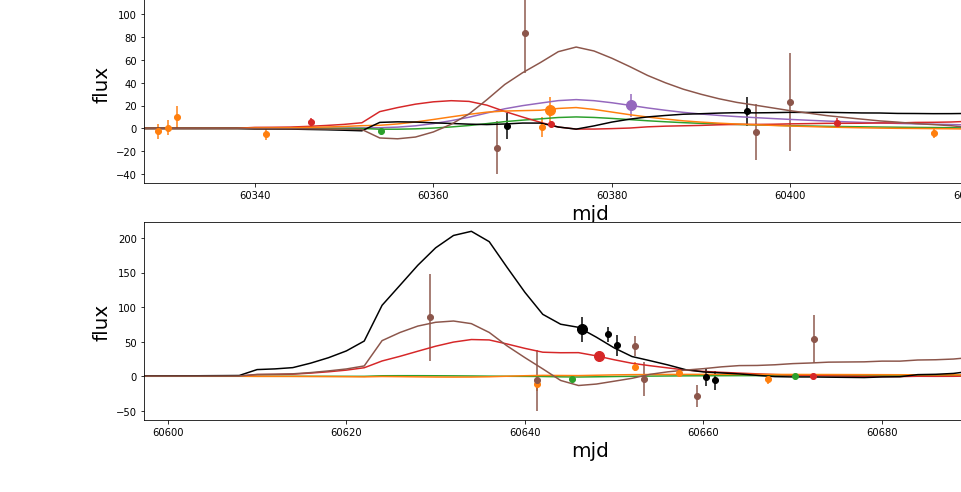

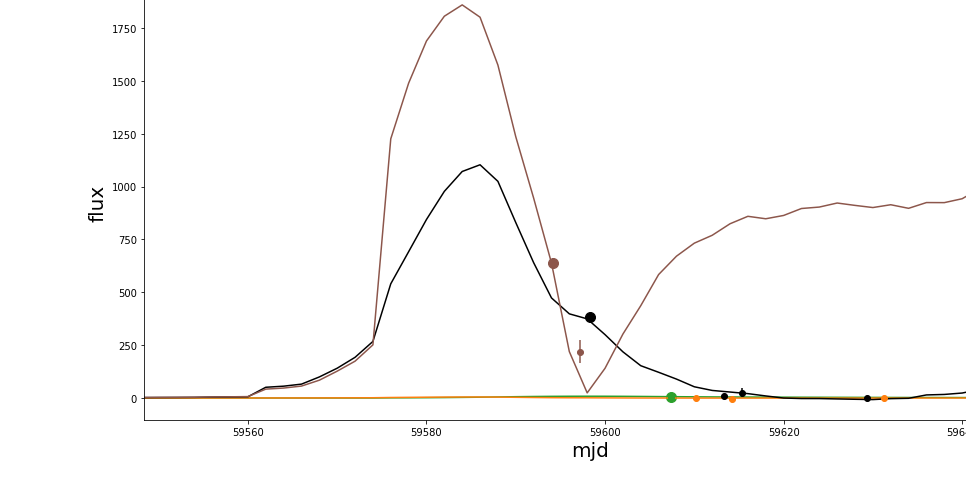

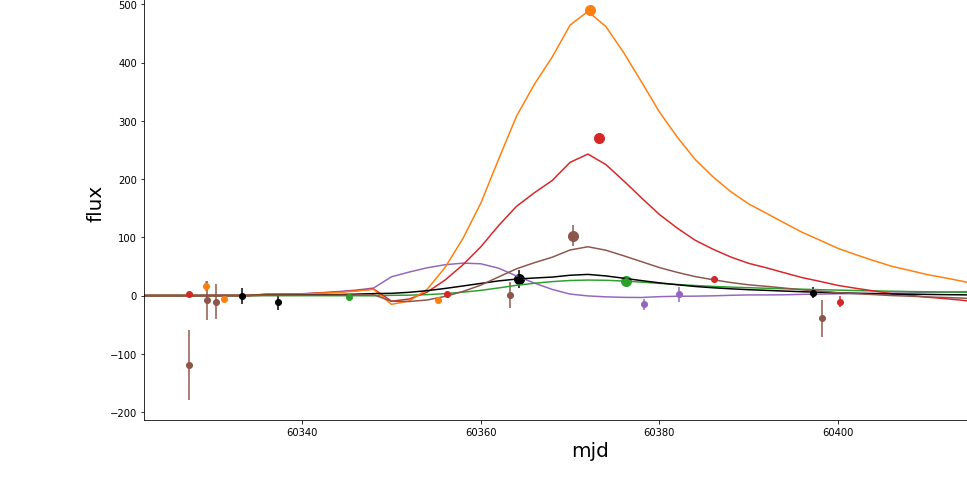

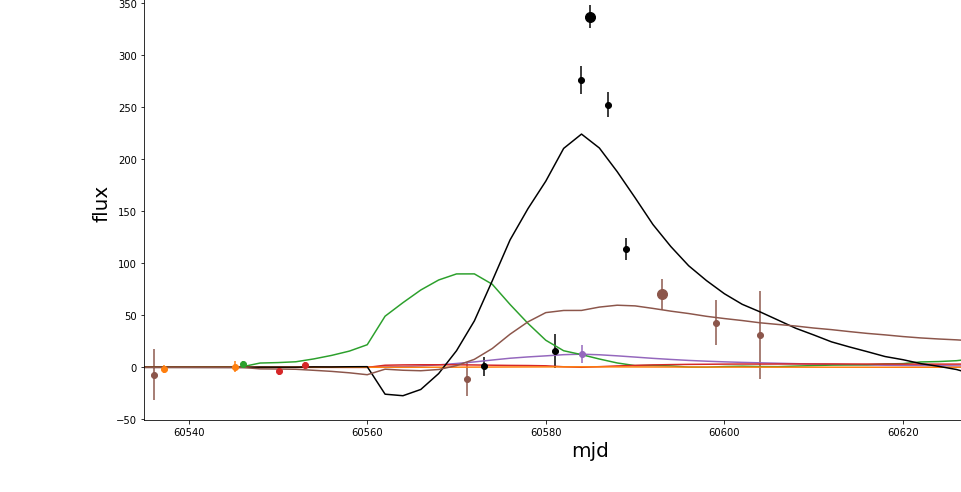

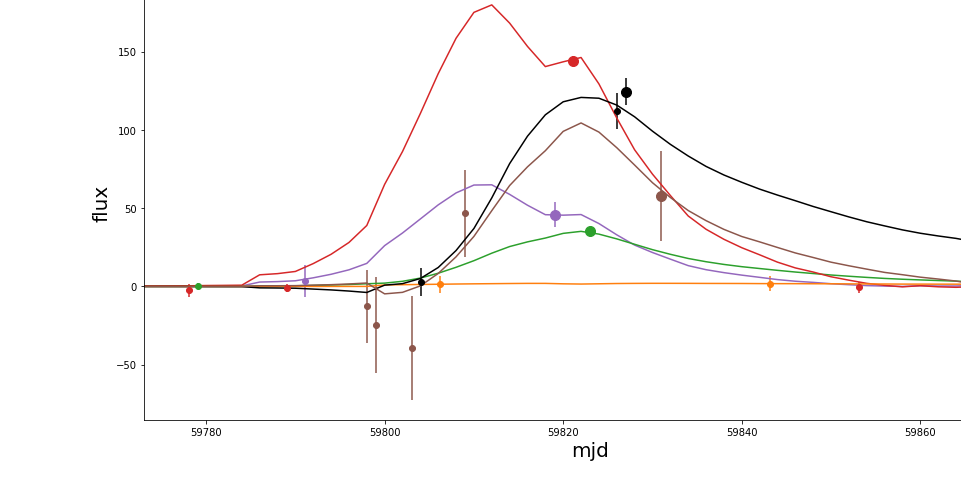

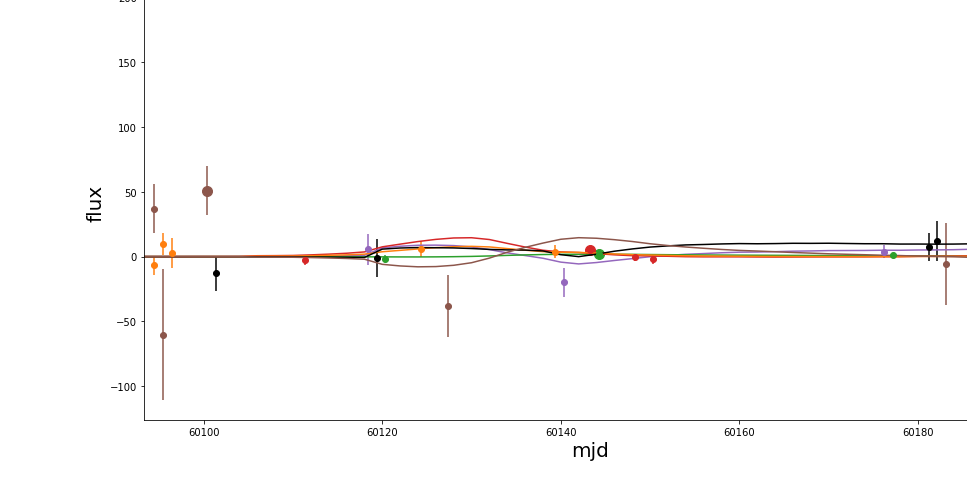

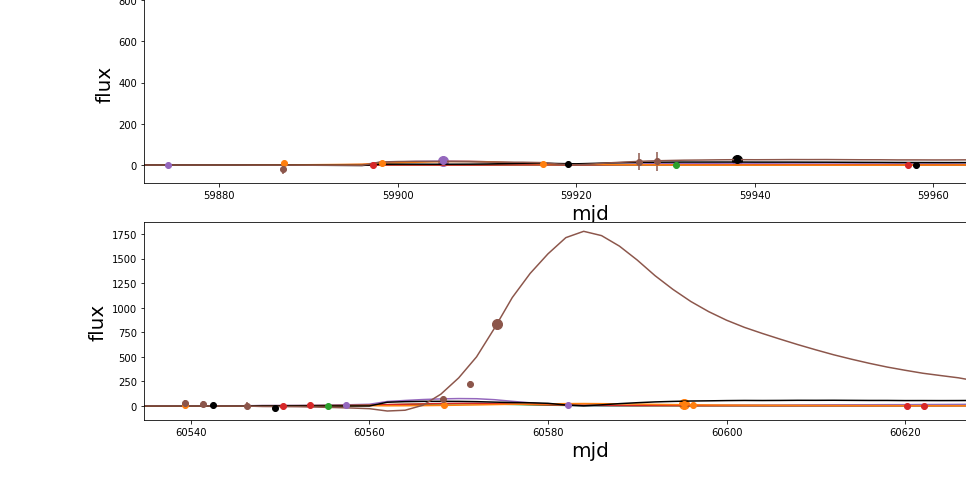

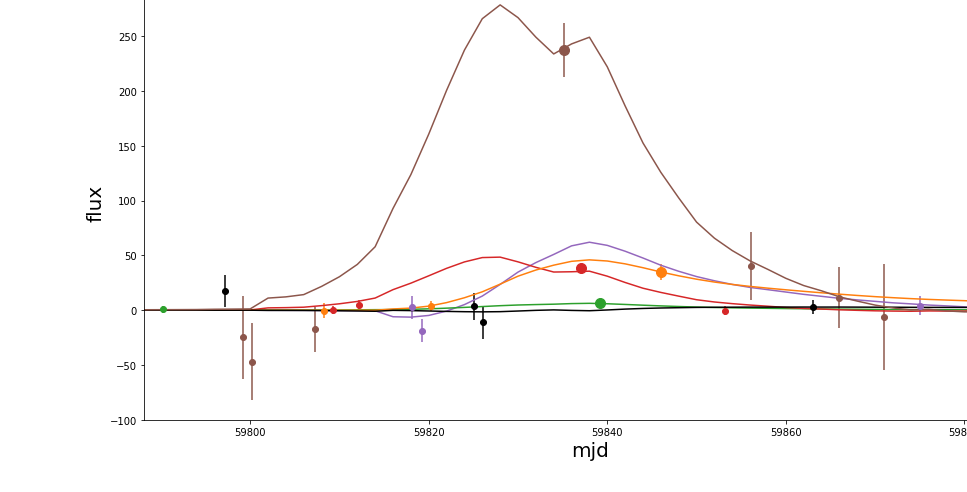

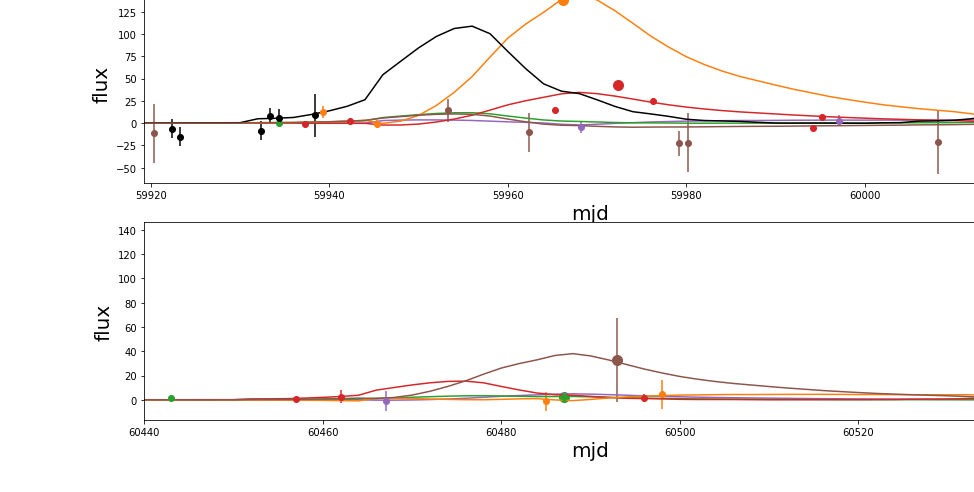

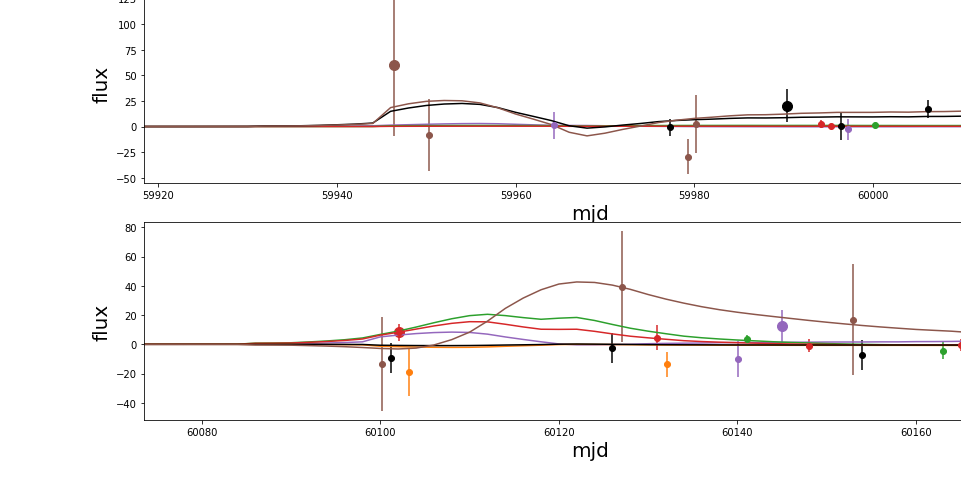

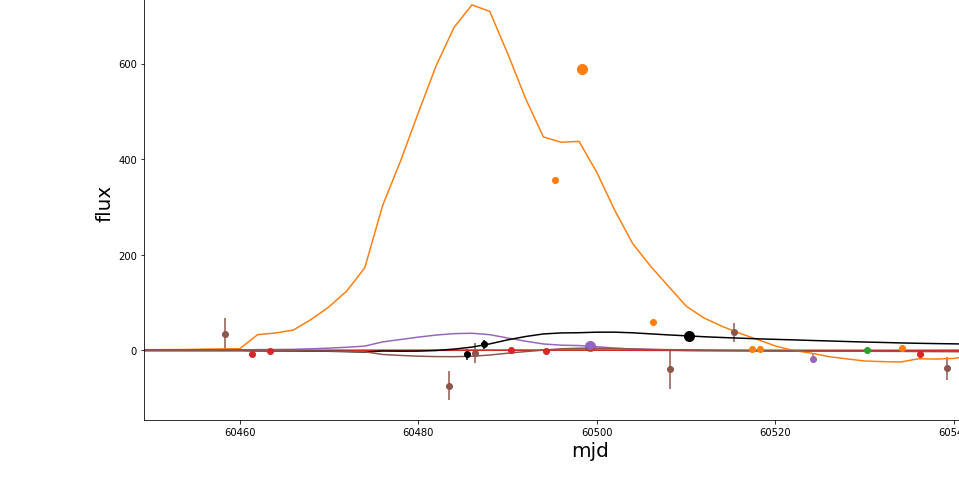

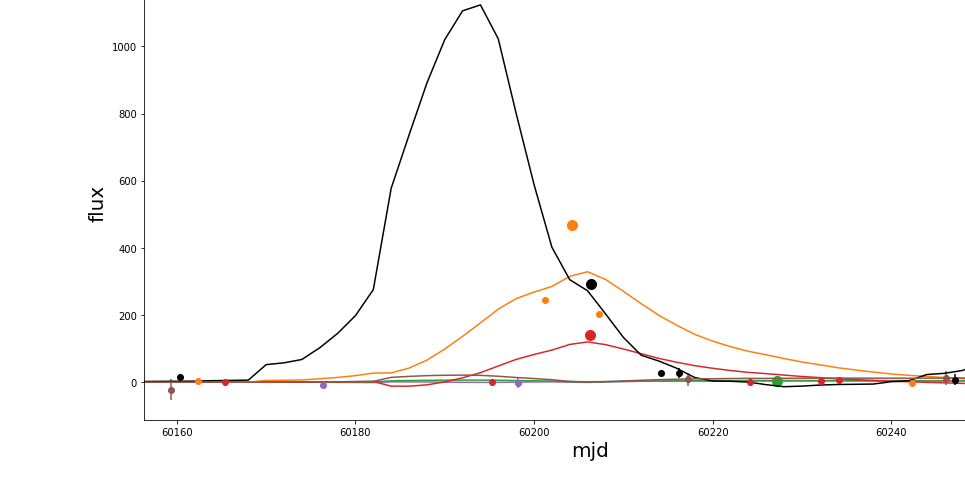

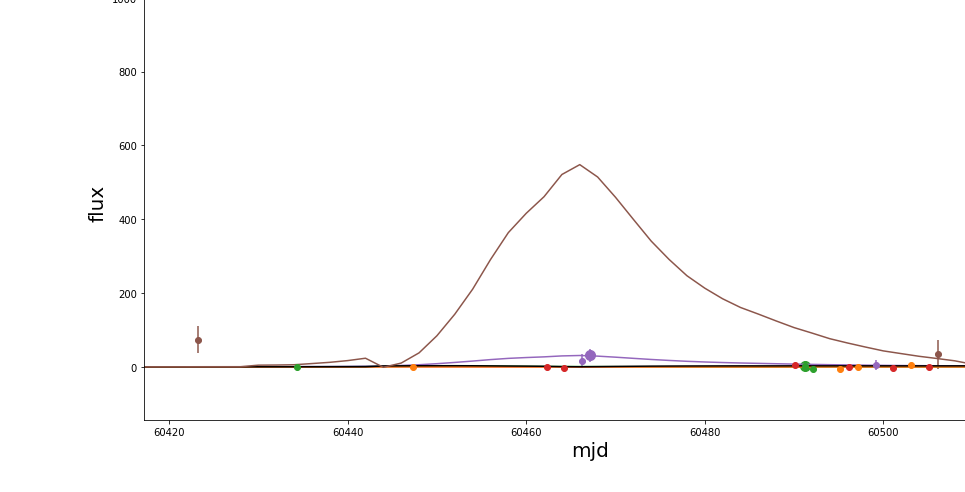

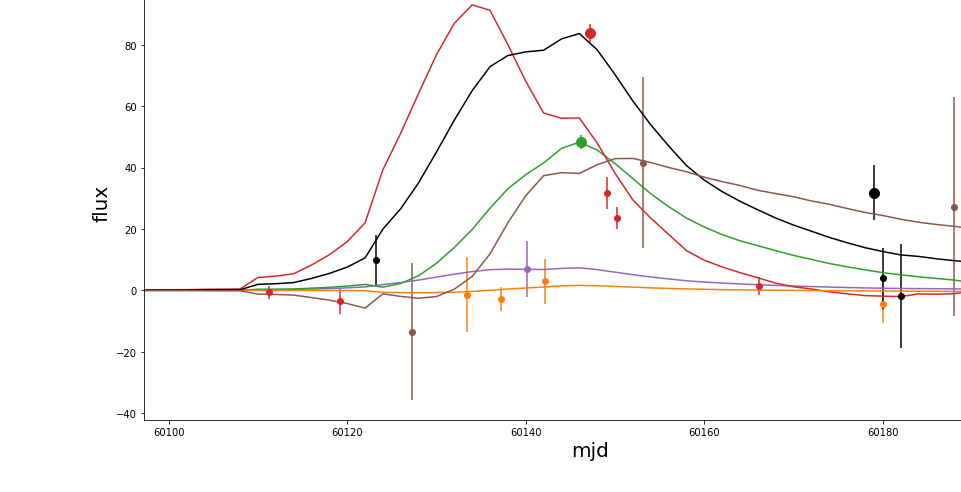

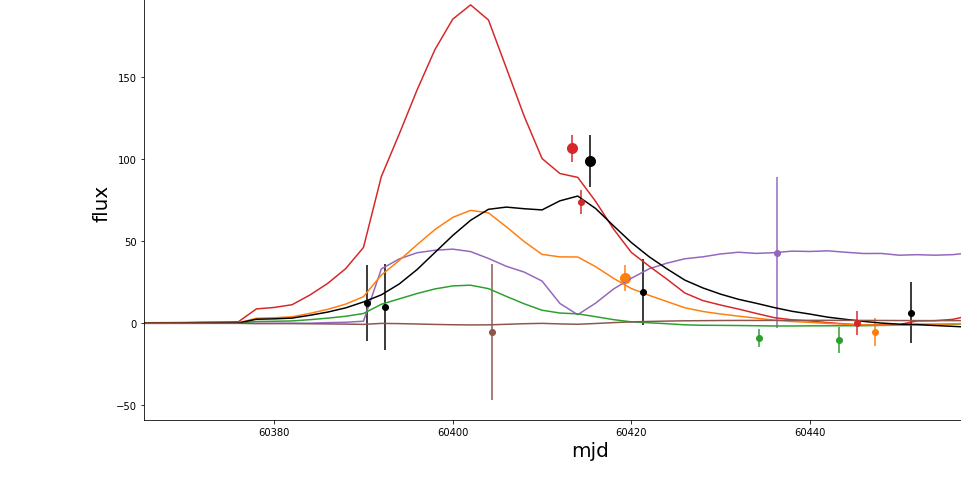

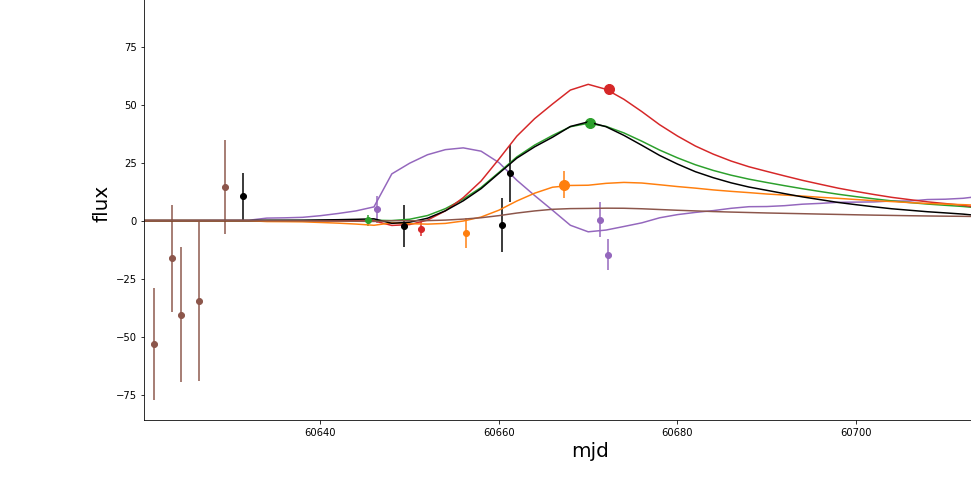

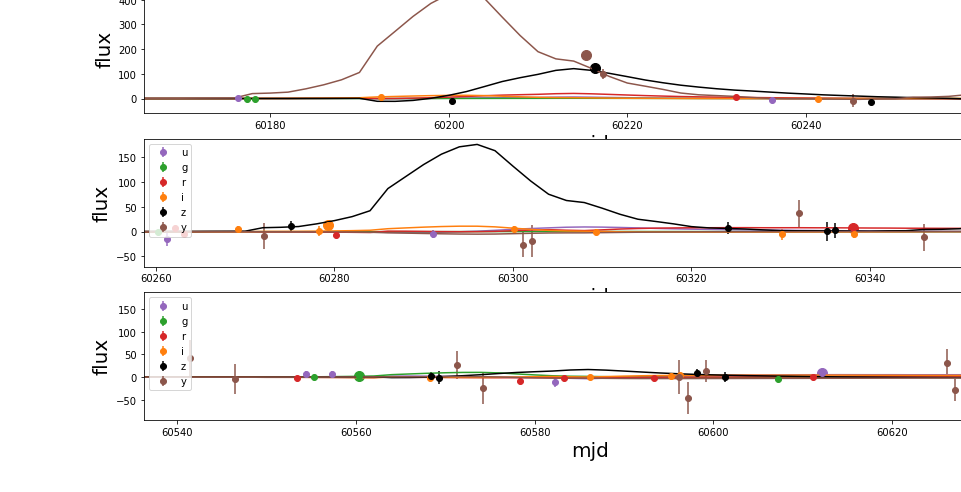

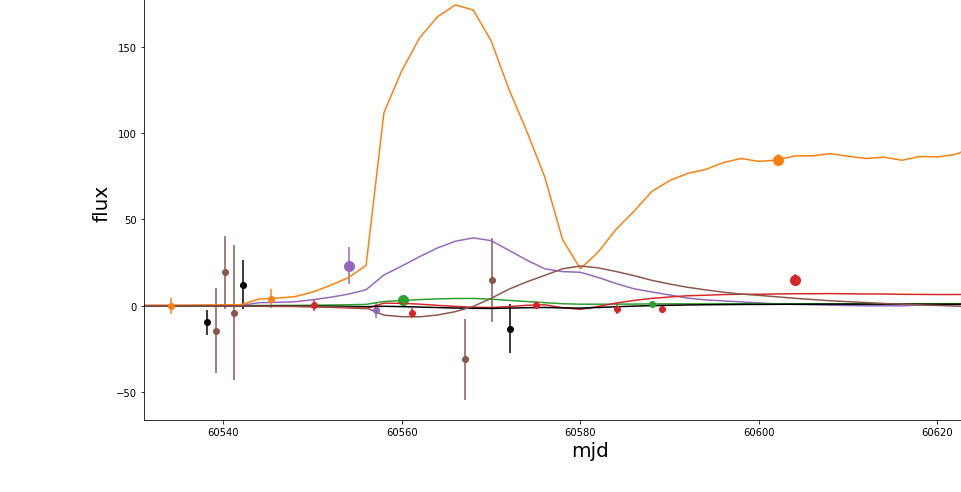

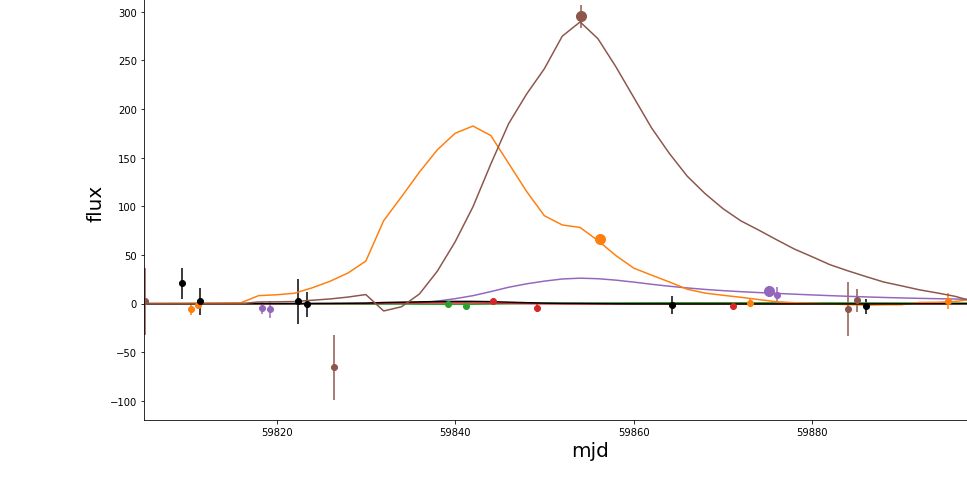

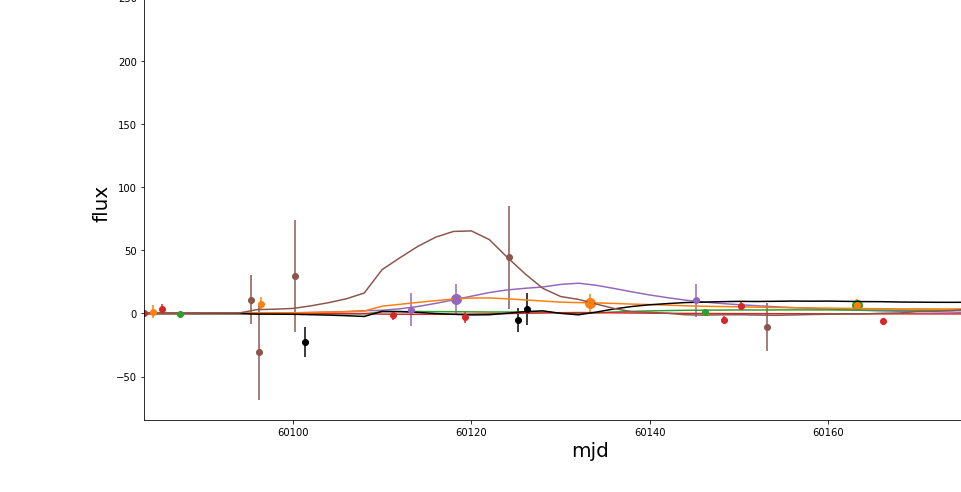

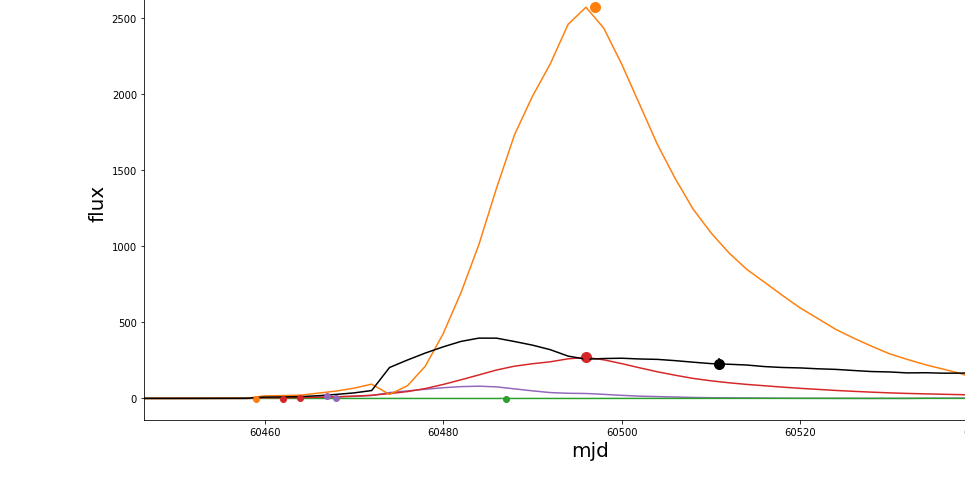

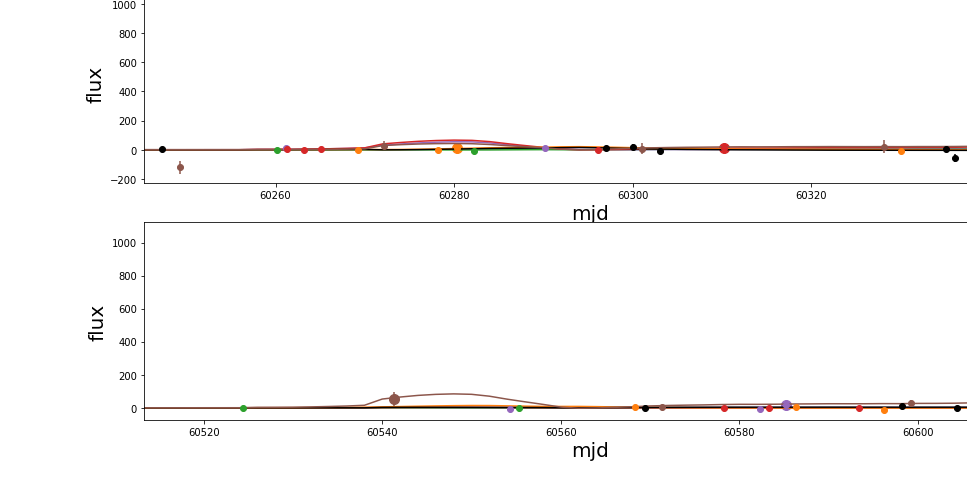

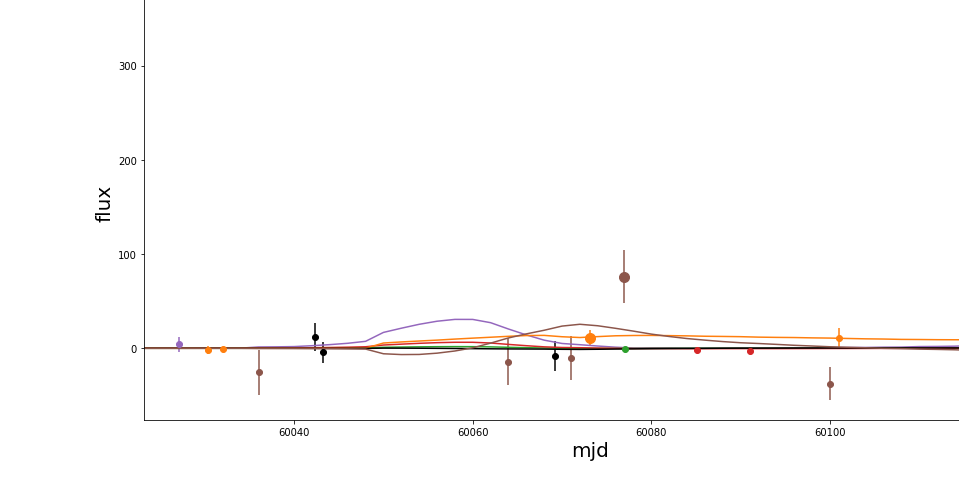

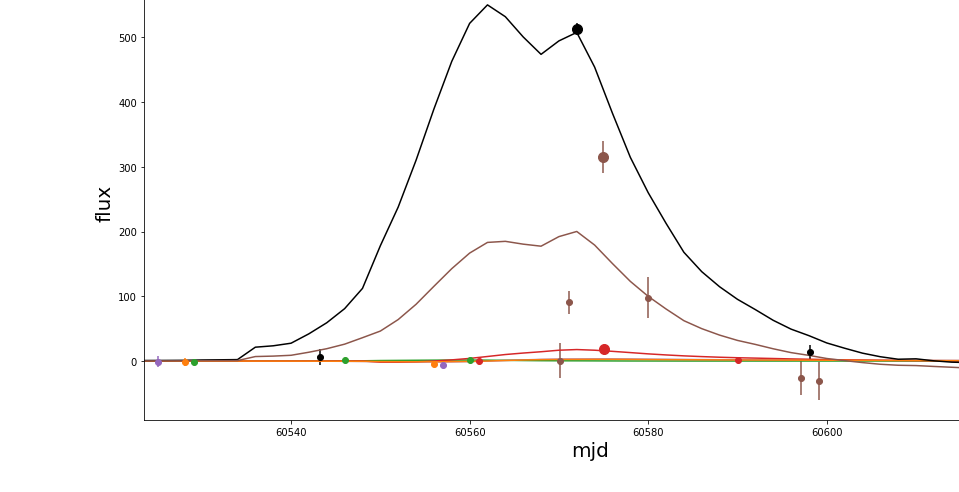

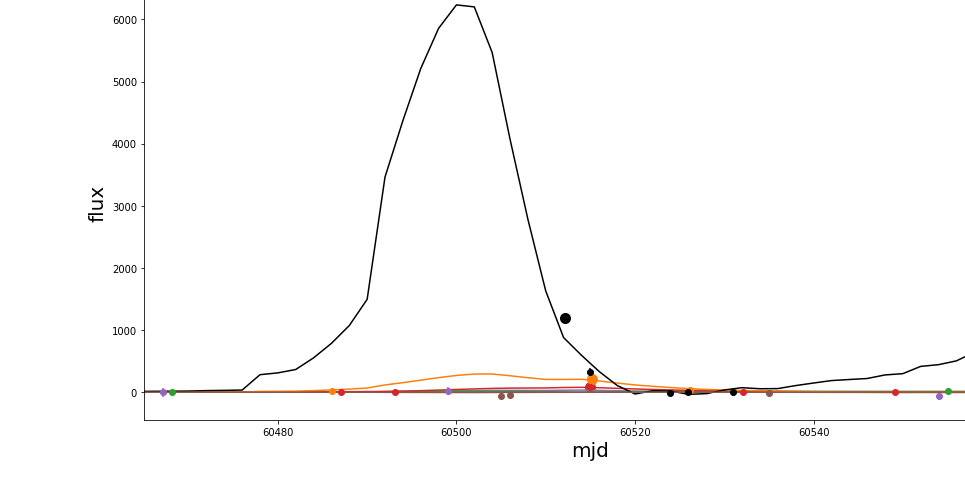

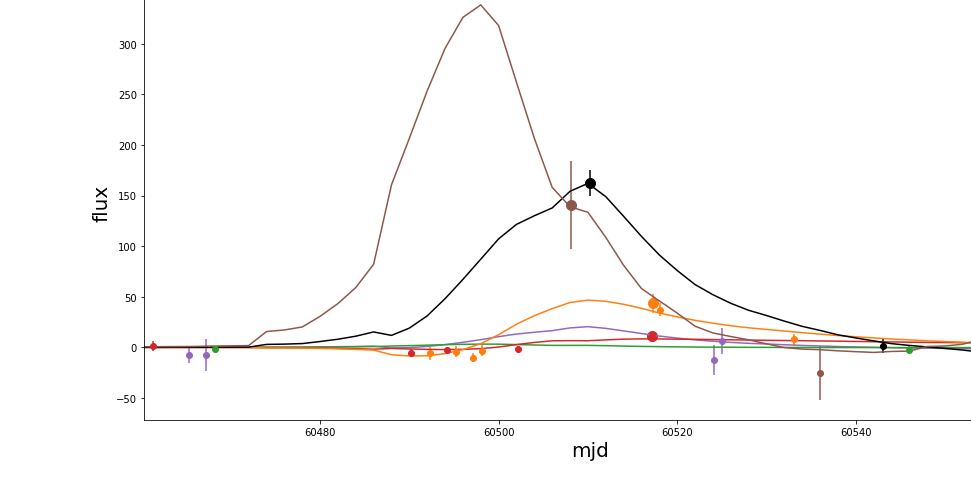

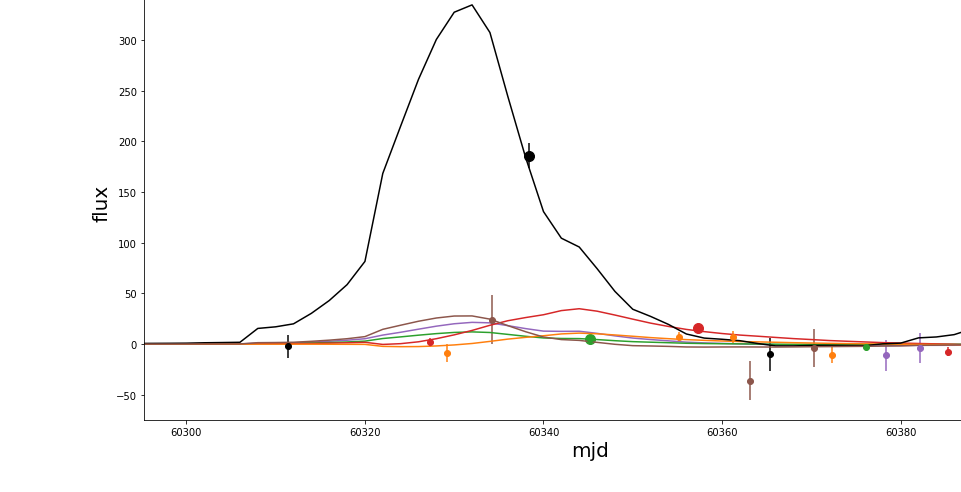

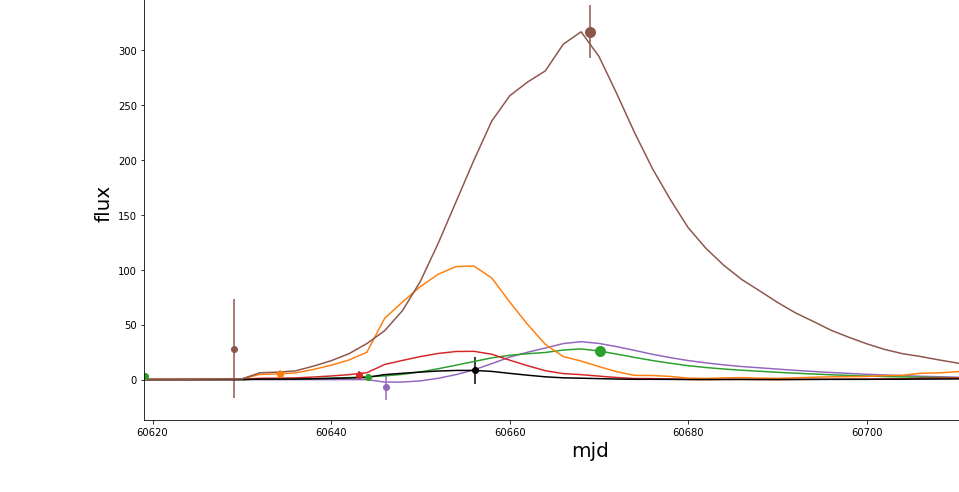

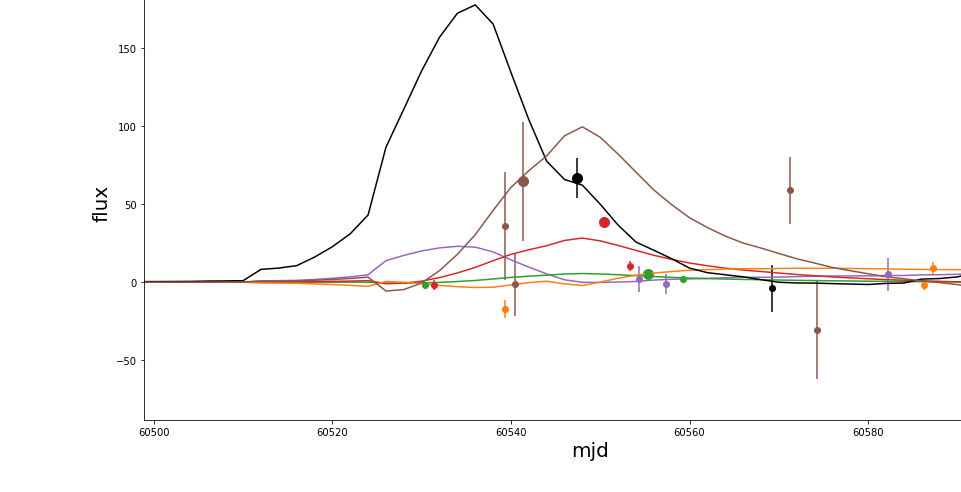

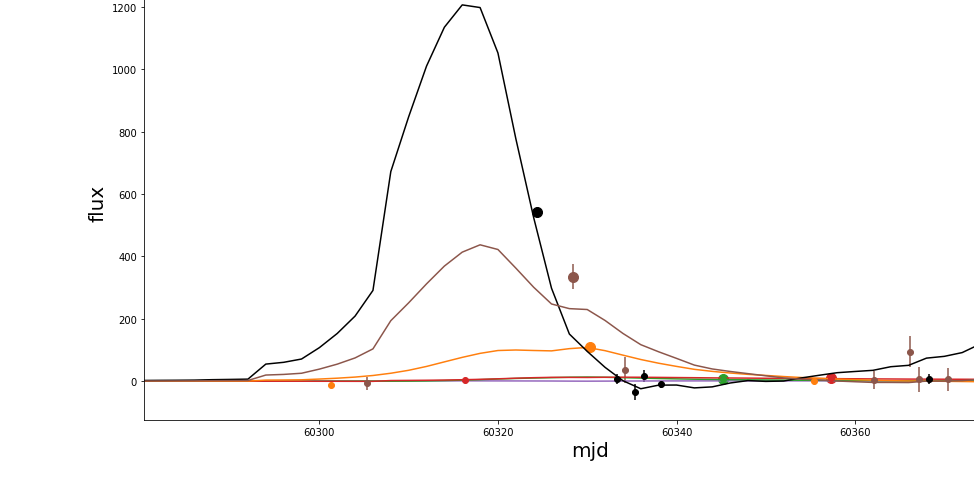

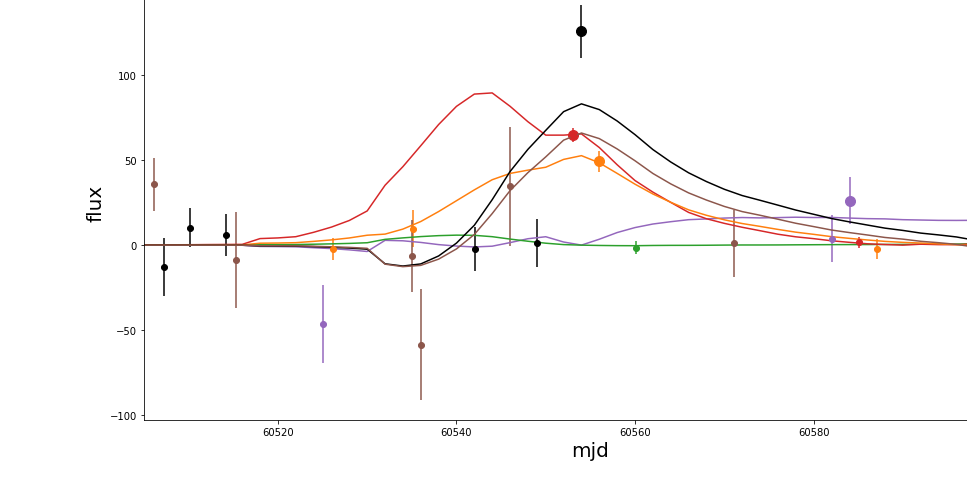

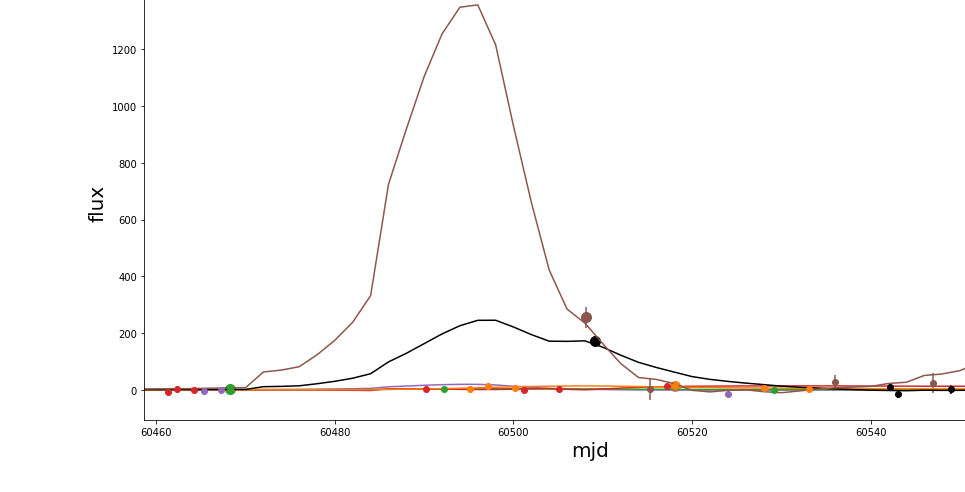

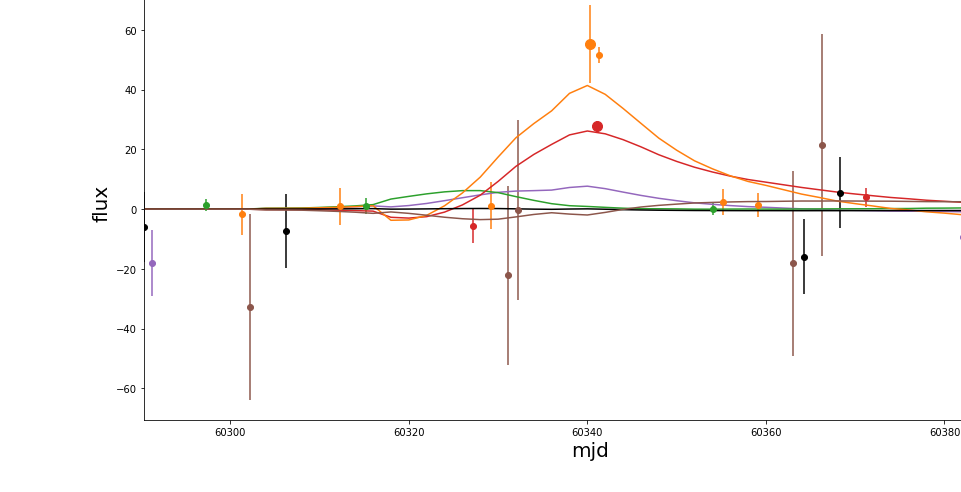

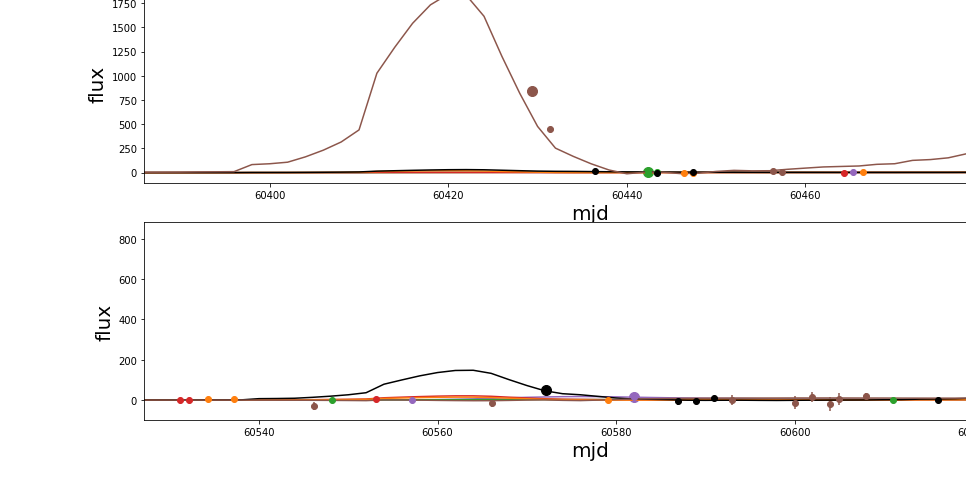

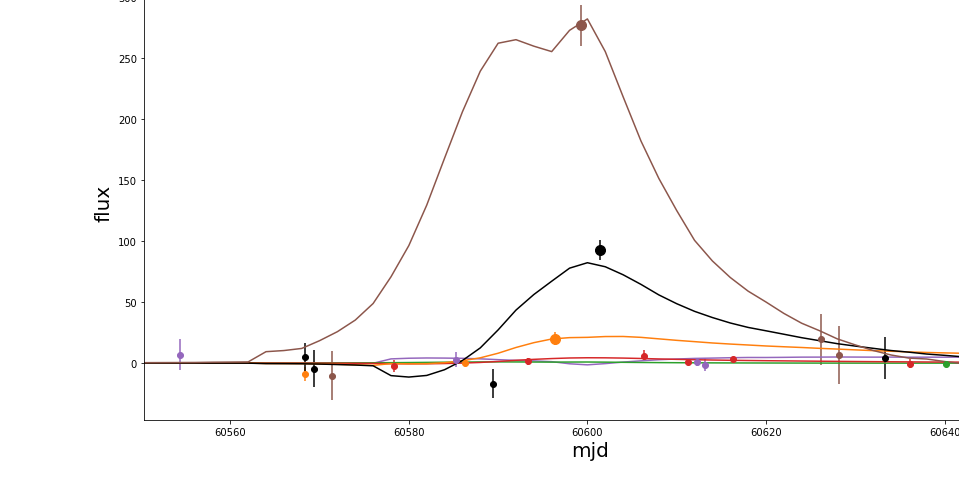

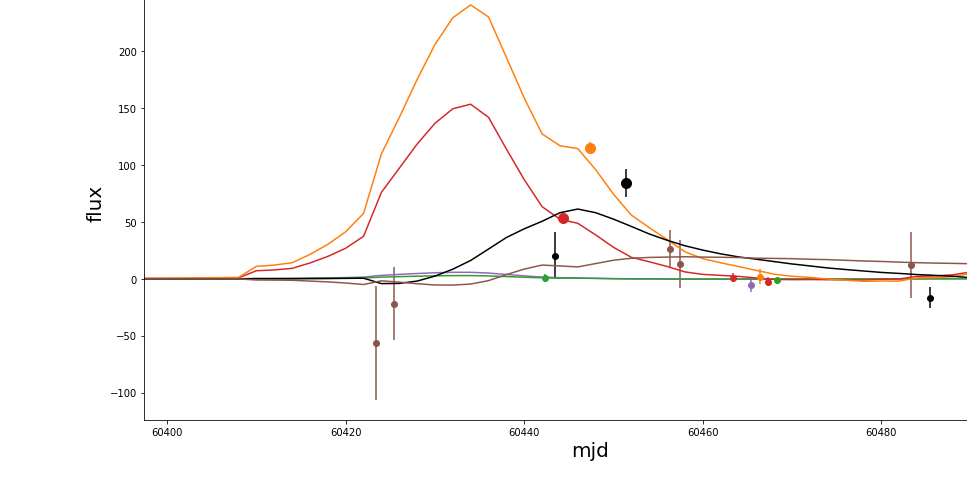

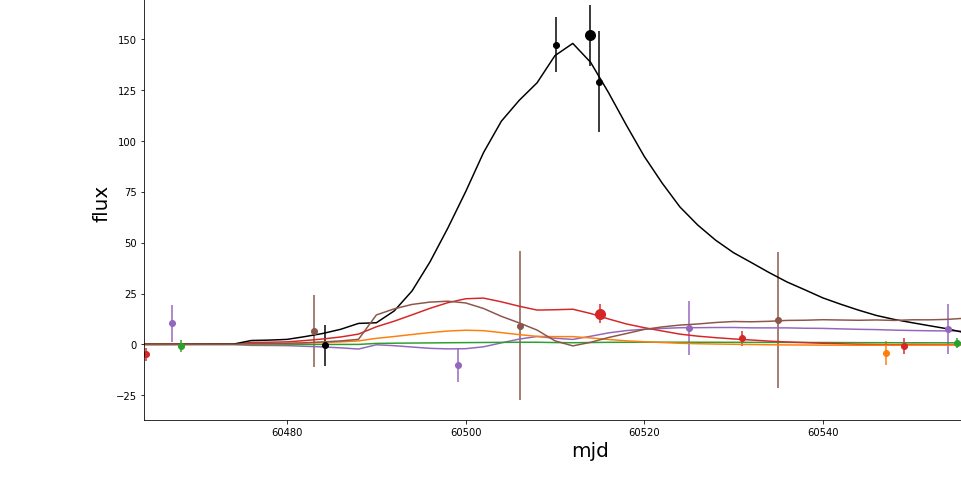

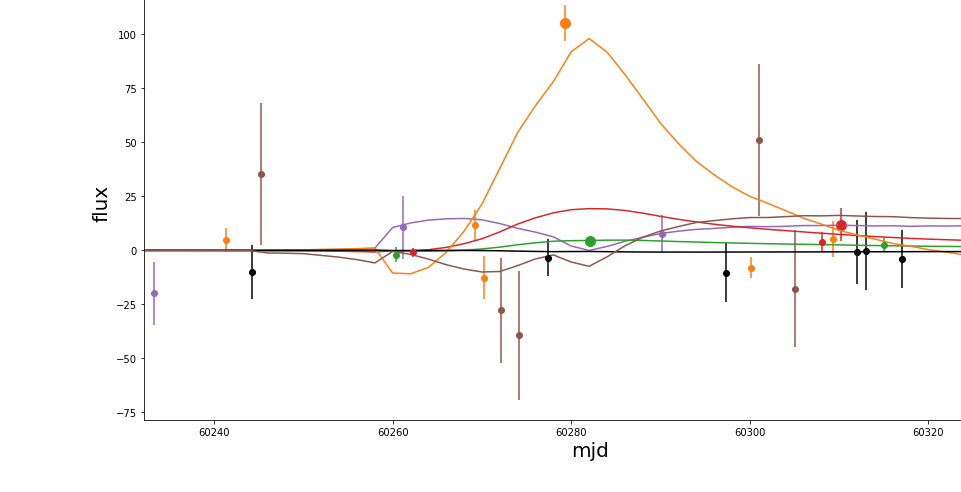

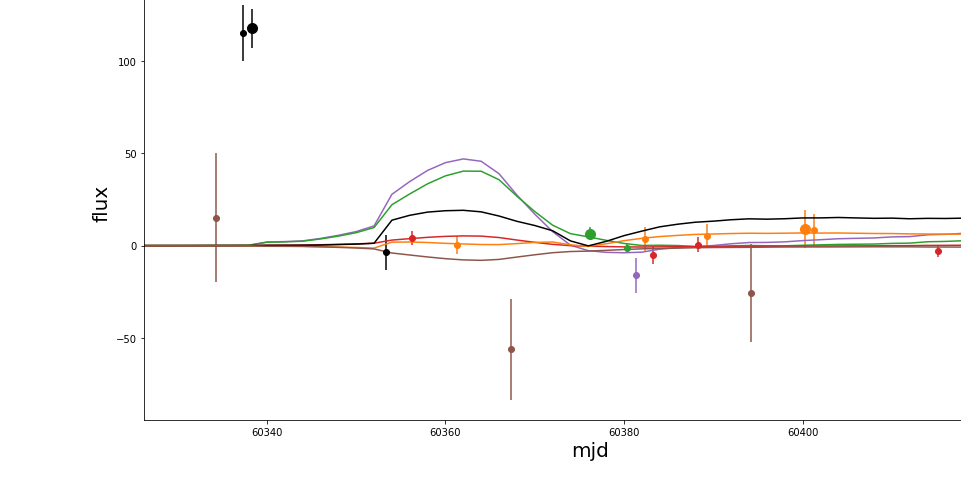

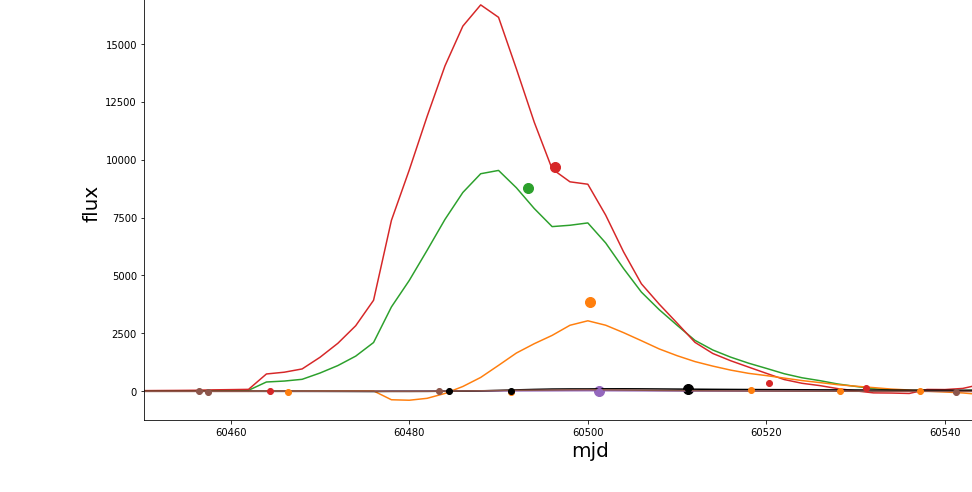

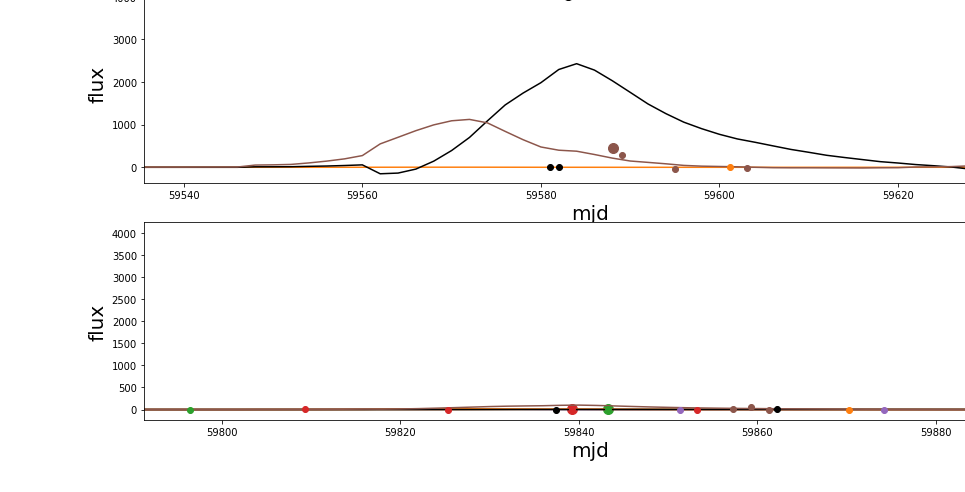

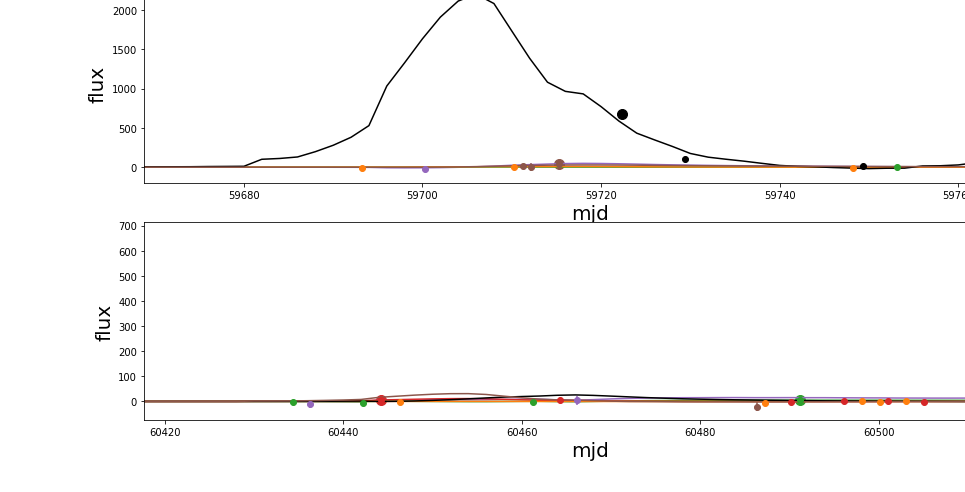

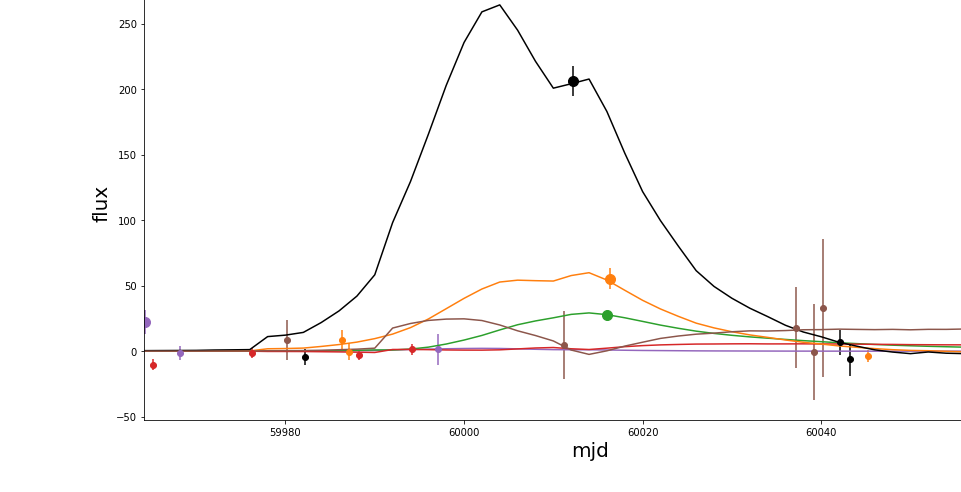

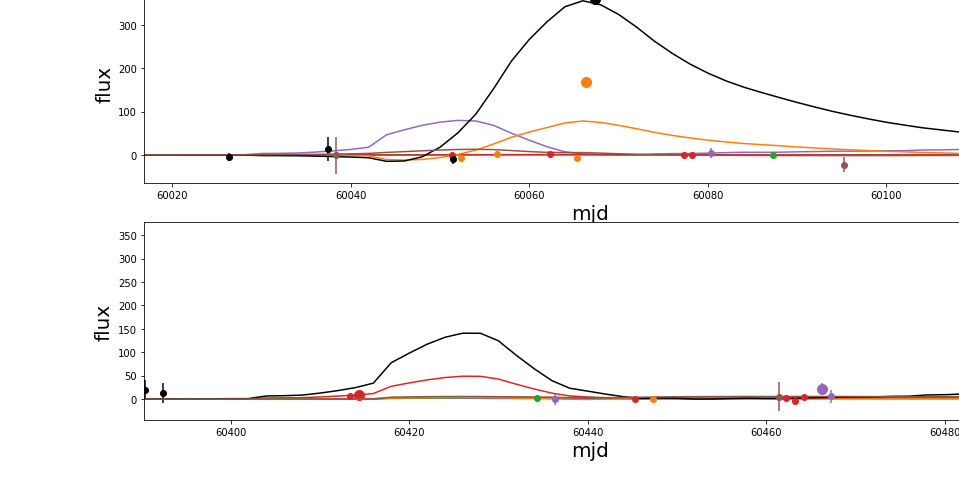

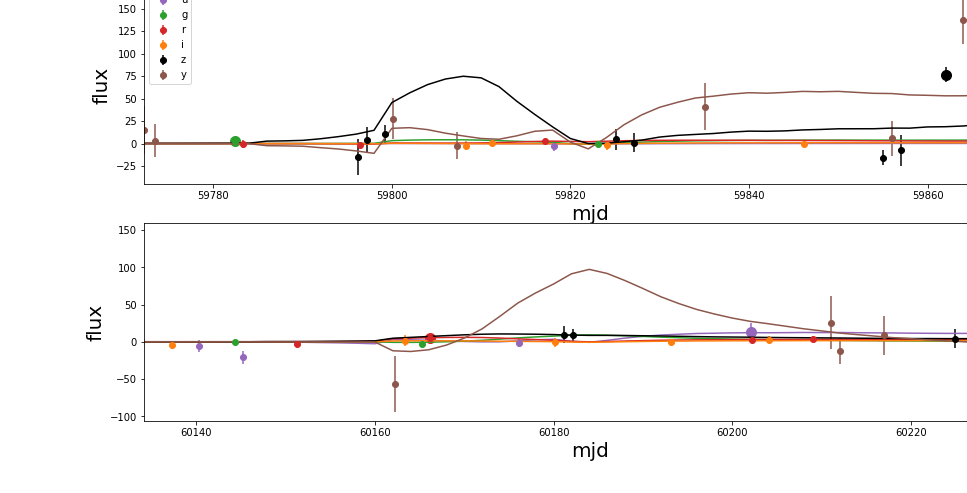

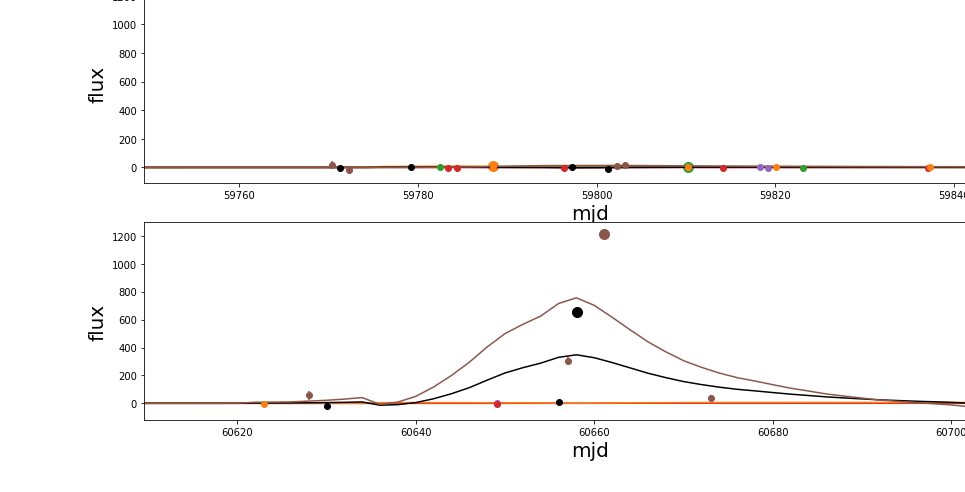

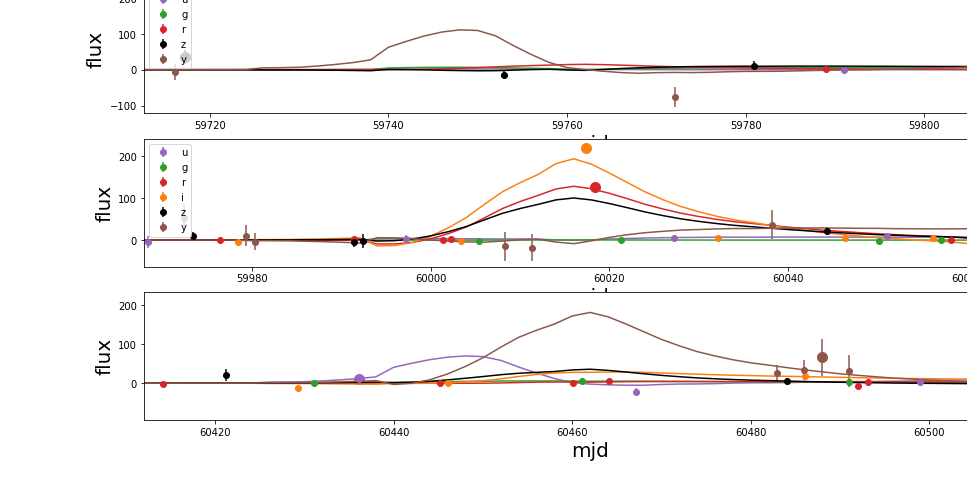

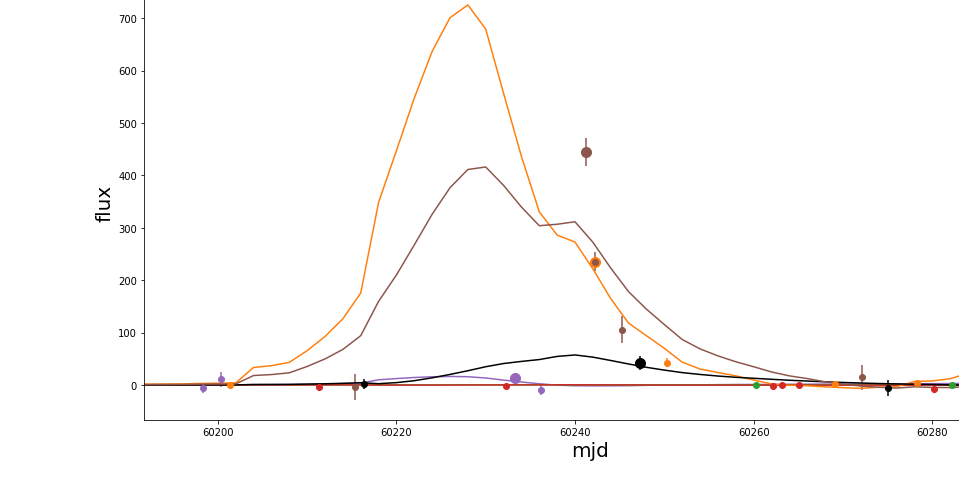

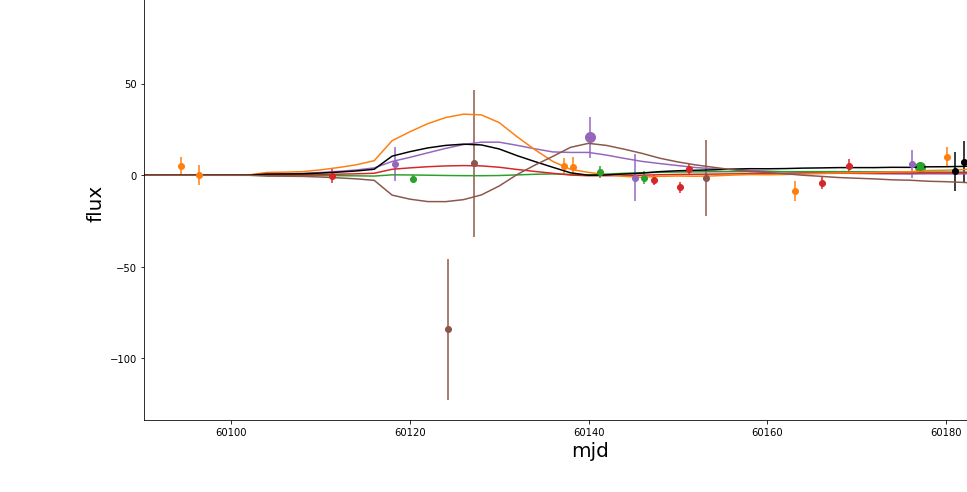

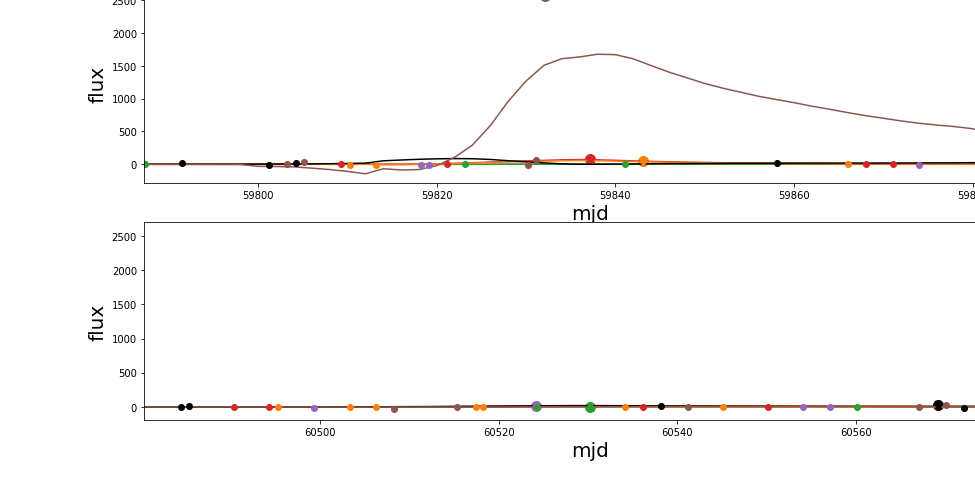

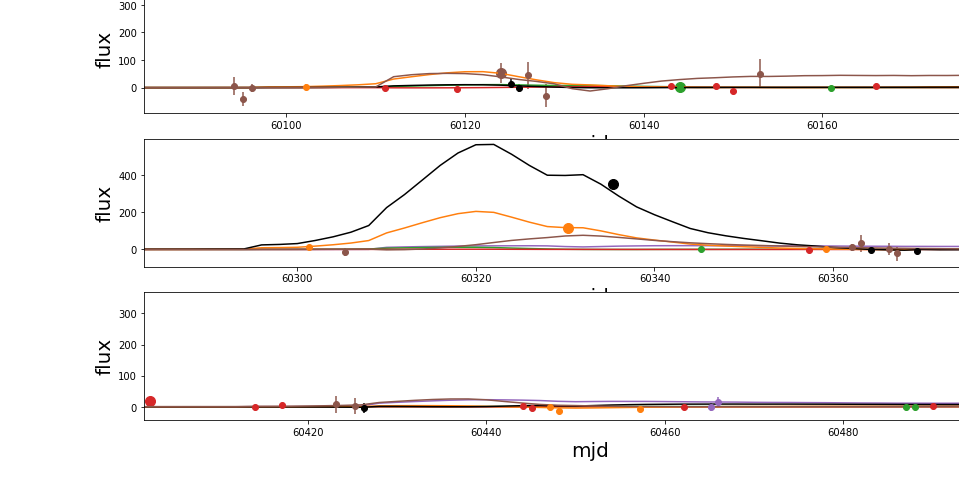

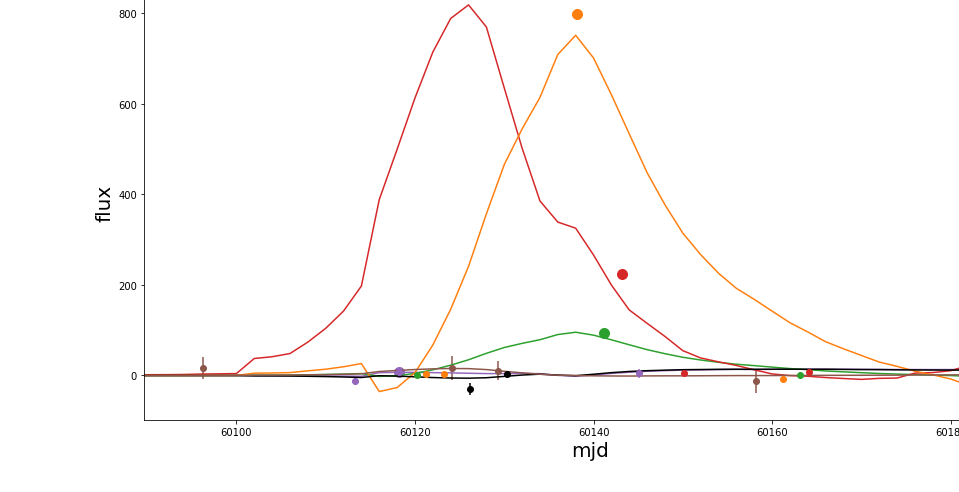

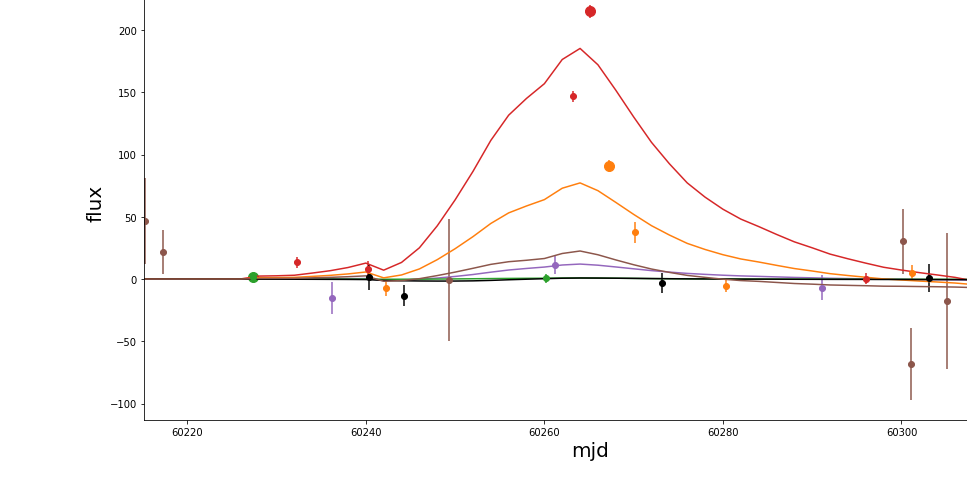

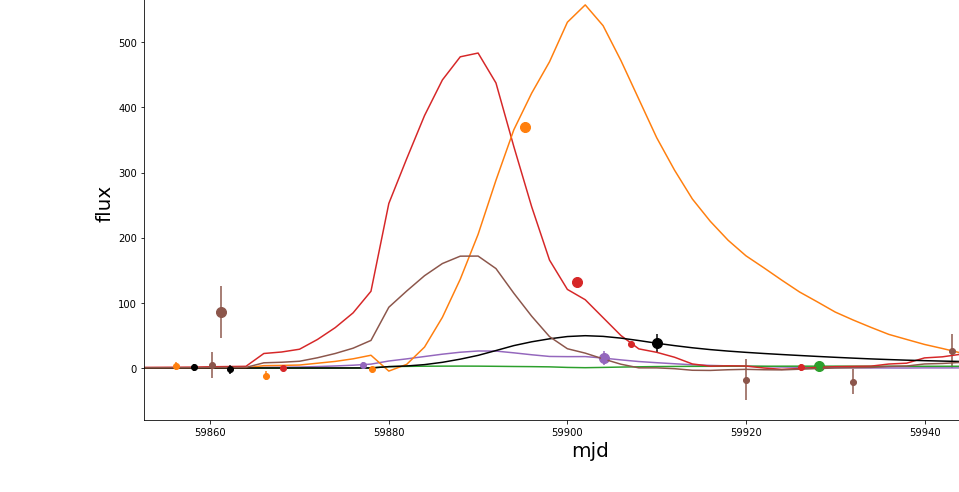

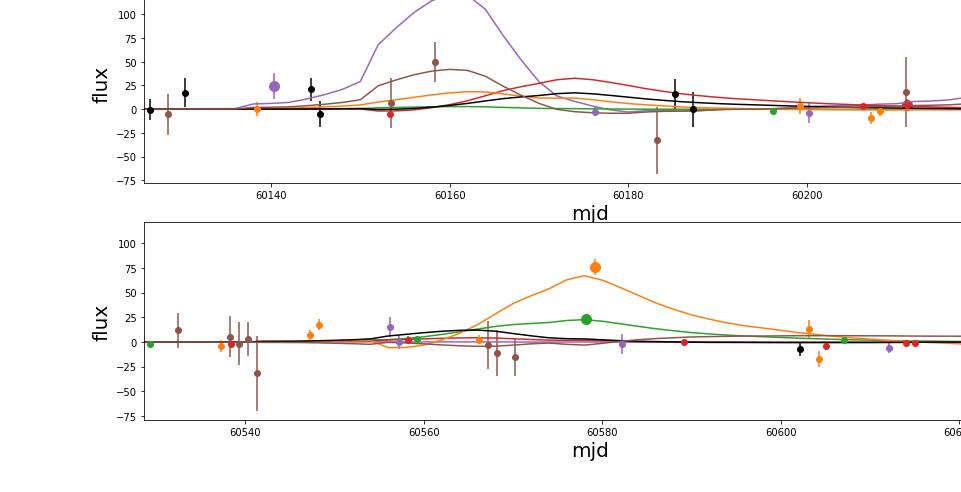

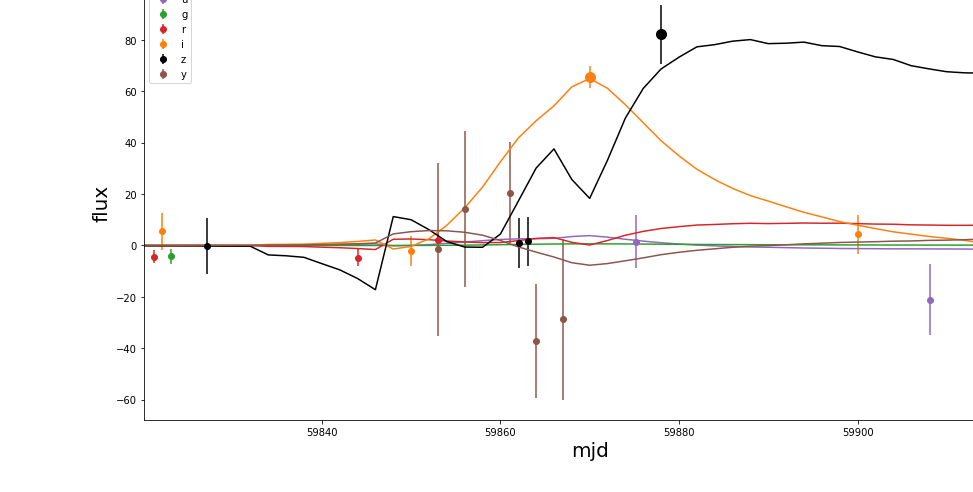

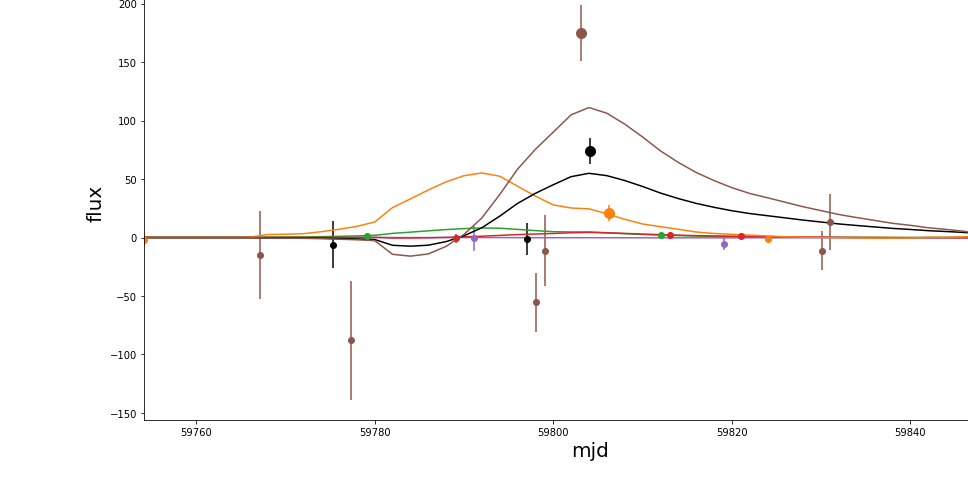

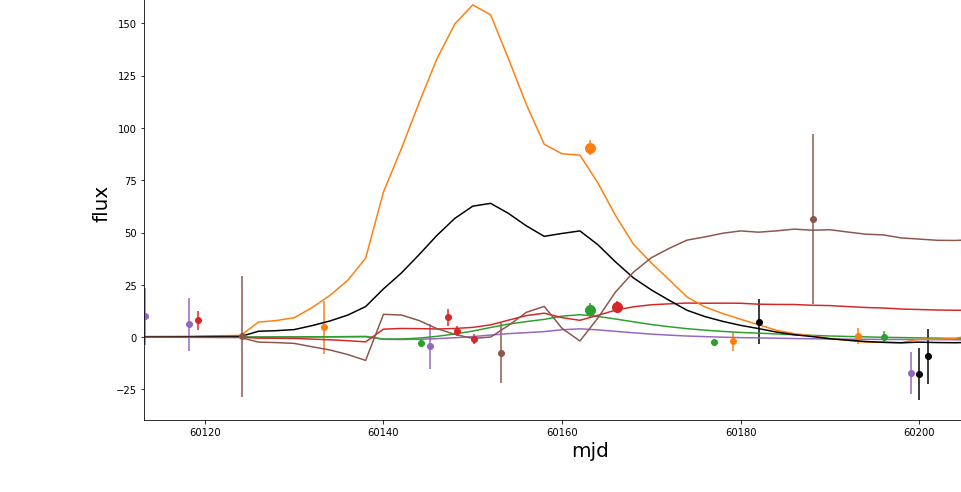

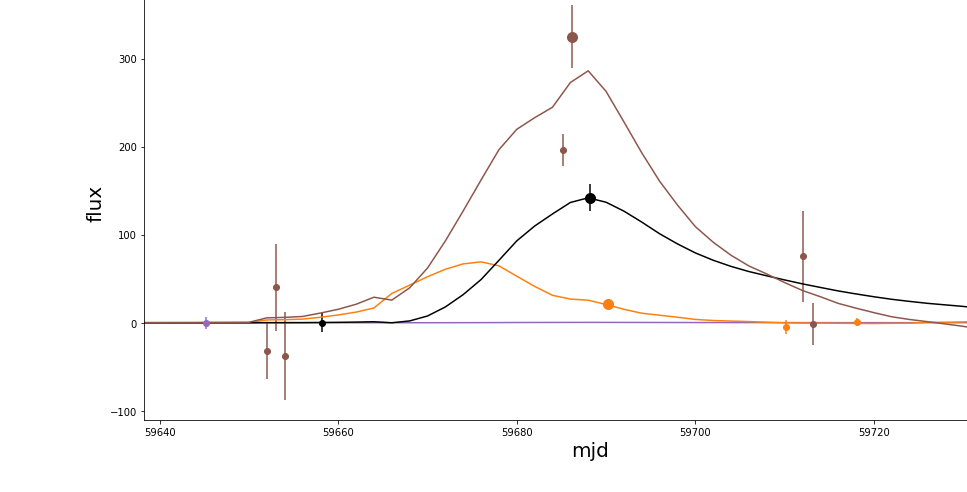

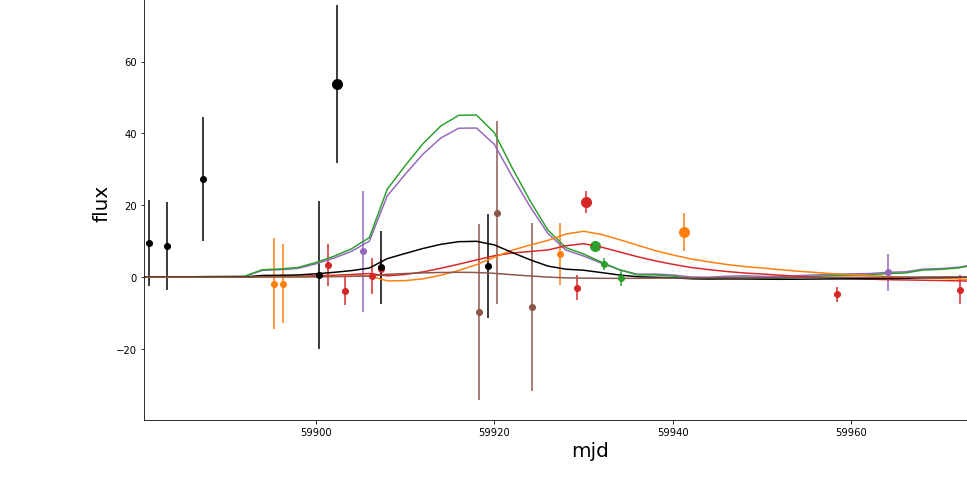

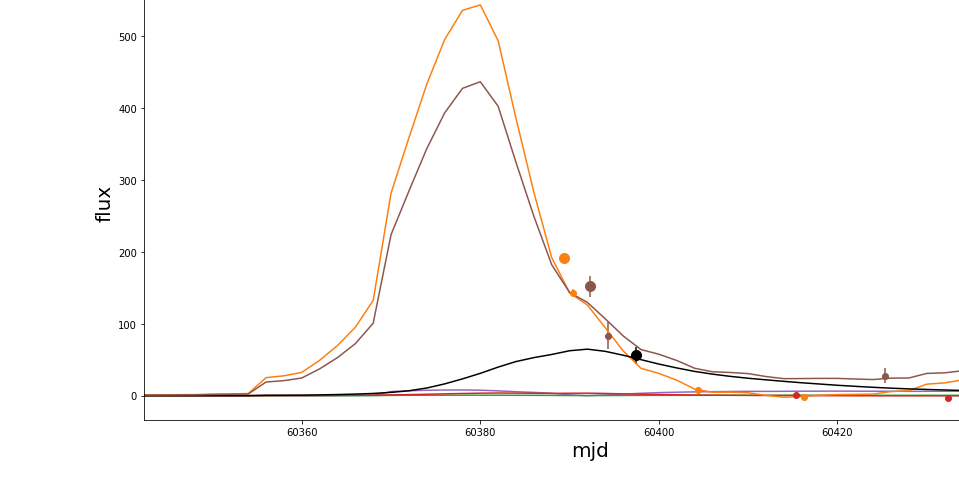

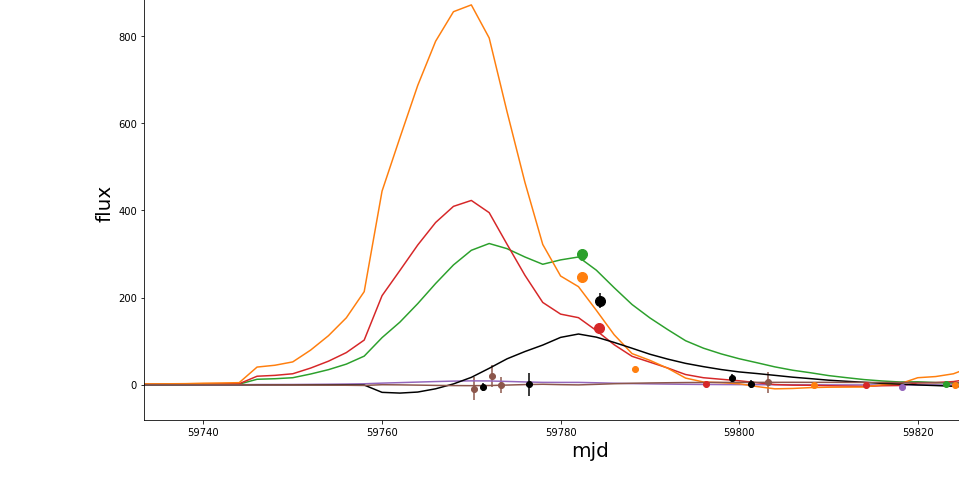

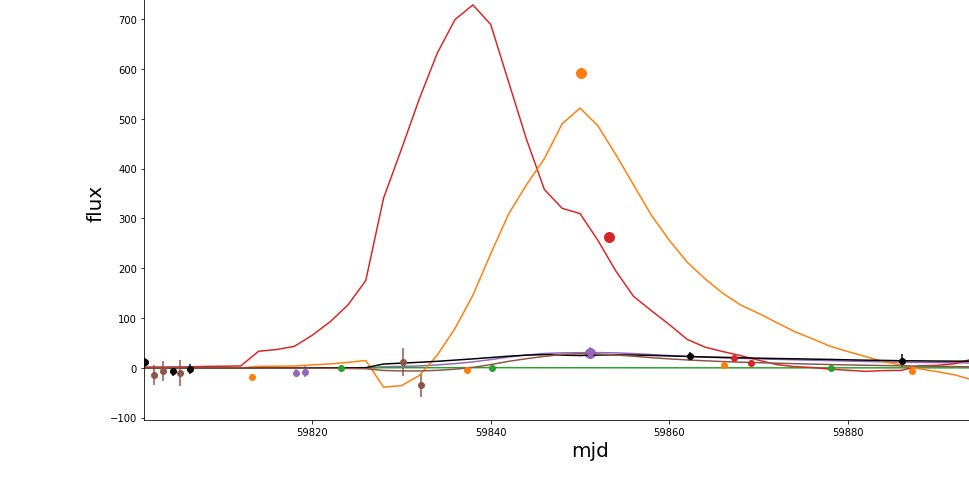

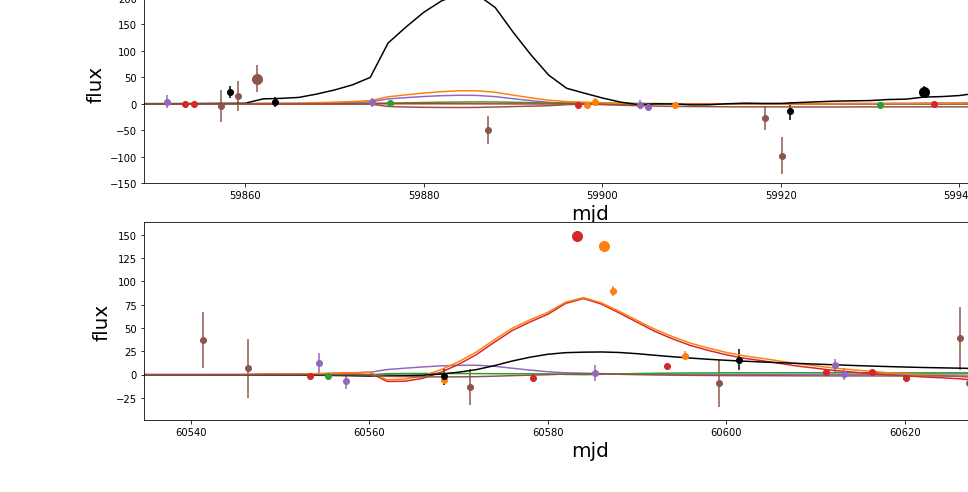

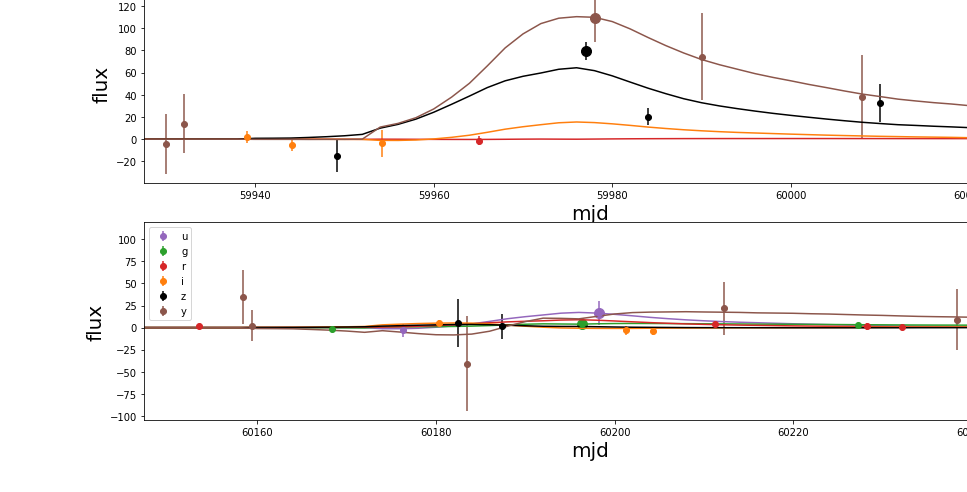

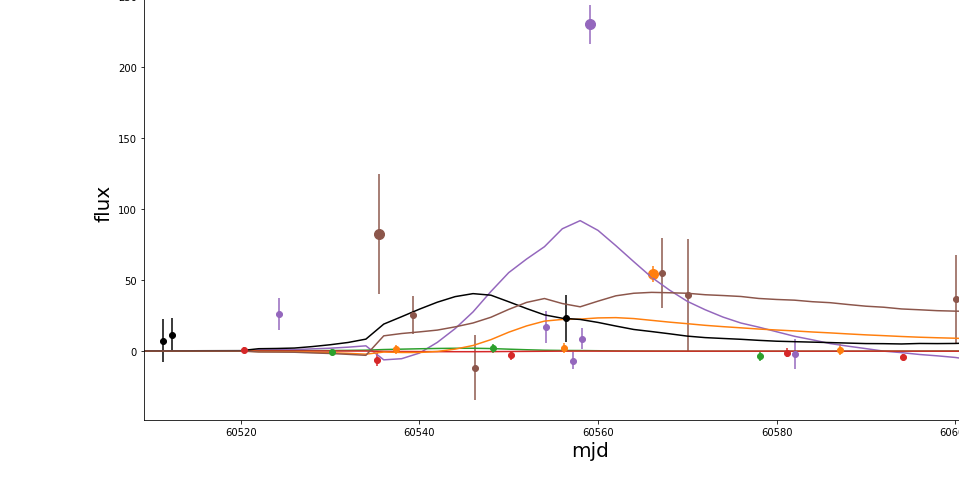

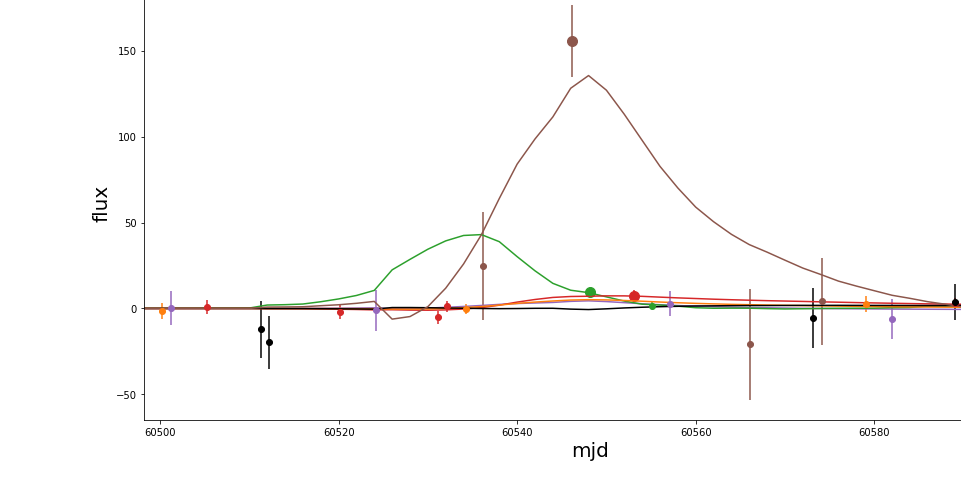

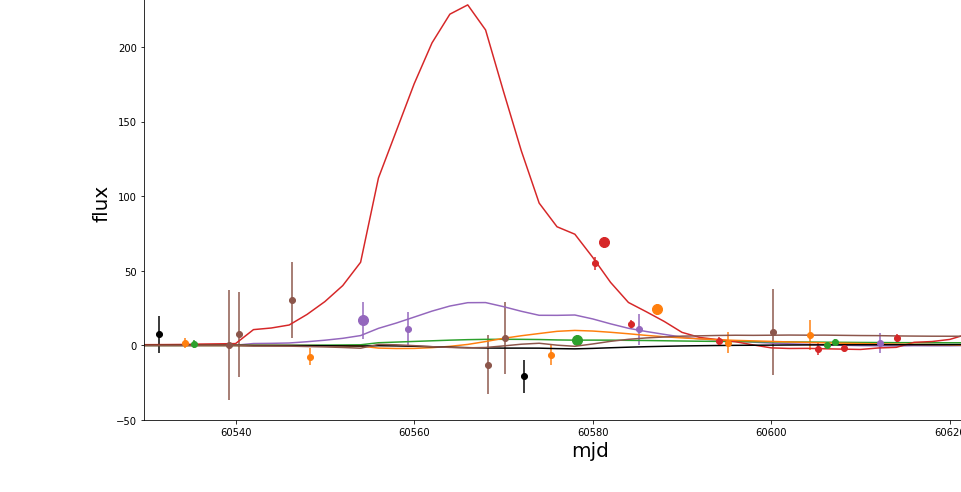

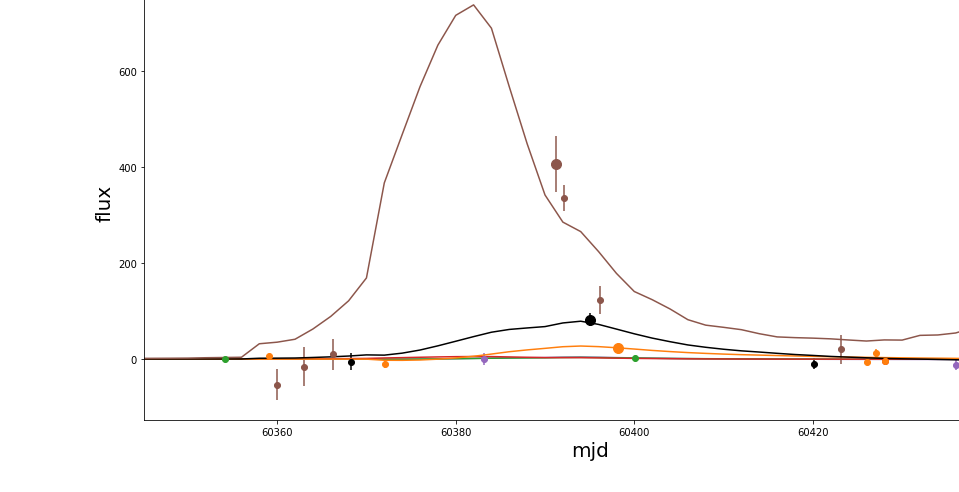

In [62]:
time_step = 2 
no_of_predicted_days = 51

for object_id in kilonova_ids:
    #print(object_id)
    event_df = data_ob.get_data_of_event(target=object_id)

    #print(event_df)
    lc = LightCurve(event_df, time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
    fig = lc.plot_max_flux_regions(color_band_dict, priority=1, plot_points=True)

    axes_list = fig.axes

    #print(axes_list)
    
    for ax in axes_list:

        right,left = ax.get_xlim()
        mid_point = (right+left)/2
        
        mid_point = mid_point-mid_point%2
        start_date=mid_point-(no_of_predicted_days-1)*time_step/2 
        end_date= mid_point+(no_of_predicted_days-1)*time_step/2 
        start_index = event_df[data_ob.time_col_name] >= start_date
        end_index = event_df[data_ob.time_col_name] <= end_date  

        
        for band in data_ob.band_map.keys():
            band_index = event_df[data_ob.band_col_name] == band
            band_df = event_df[band_index&start_index&end_index]
            if len(band_df)>0:
                #print(band_df)
                binned_dates = get_binned_time(band_df)
                b2 = (binned_dates-mid_point+no_of_predicted_days-1)/2
                b2 = b2.astype(int)
                light_curve_seg = np.zeros((no_of_predicted_days))
                max_flux_val = np.amax(band_df[data_ob.flux_col_name])       
                #light_curve_seg[b2[:]] = band_df[data_ob.flux_col_name]/max_flux_val
                light_curve_seg[b2[:]] = band_df[data_ob.flux_col_name]
                #print(light_curve_seg)

                #initial_guess = np.zeros((PCs.shape[0]))
                initial_guess = [.93,.04 ,.012]
                result = least_squares(calc_loss, initial_guess, args=(PCs, light_curve_seg))
                
                #result = curve_fit(calc_loss, xdata= PCs, ydata= light_curve_seg, p0= initial_guess, args=(PCs, light_curve_seg))

                predicted_lt_curve = predict_lt_curve(result.x,PCs)
                #print(predicted_lt_curve)
                x_data = np.arange(start_date,end_date+2,2)
                ax.plot(x_data,predicted_lt_curve, label="predicted", color=color_band_dict[band])

    plt.savefig("Linear_combinations/"+ dataset+ "/"+str(object_id)+"all_bands_")
    plt.show()
    plt.close('all')

    #print("----------------------------------------------------------")

In [ ]:
print(result.x)
PC

In [ ]:
PCs.shape

In [ ]:
fig = plt.figure(figsize=(10,5))
for i in range(5):
    PC = PCs[i]
    x = np.arange(0,102,2)
    plt.plot(x,PC,label = "PC "+str(i+1))

plt.xlabel("days", fontsize = 20)
plt.ylabel("normalized flux", fontsize=20)
    
plt.legend()
plt.title("Plot of Principle Components",fontsize=30)
#fig.savefig("Plot of PCs")
plt.show()